# Plots the summary results for the motif search

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from os.path import isfile, join
from itertools import compress
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.backends.backend_pdf
from scipy.stats import nbinom

### helper functions

In [2]:
def generate_kmer_inx():
    vals = {'A':0,'C':1,'G':2,'T':3}
    l = 3 #core length
    kmer_inx = {}
    for p in list(itertools.product(vals.keys(), repeat=l)):
        inx = 0
        for j,base in enumerate(p):
            inx += (4**j)*vals[base] 
        kmer_inx[''.join(p)] = inx
    return kmer_inx

#assignes each kmer to an index and visa versa
kmer_inx = generate_kmer_inx()
inx_kmer = {y:x for x,y in kmer_inx.items()}

In [3]:
#reads the np.array files and extract the parameters
#the distance parameters (last 3) are exp'ed to stay positive
def read_params(files):
    n_additional = 3 #non parameters saved at the end
    n_exped = 3 #parameters kept positive through log exp trick
    params = []
    for f in files:
        param = np.loadtxt(join(param_dir, f))
        param[-n_additional-n_exped:-n_additional] = np.exp(param[-n_additional-n_exped:-n_additional])
        param[-n_additional-1] = param[-n_additional-1]/(1+param[-n_additional-1])
        params.append(param)      
    return params

### read files SELEX

/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

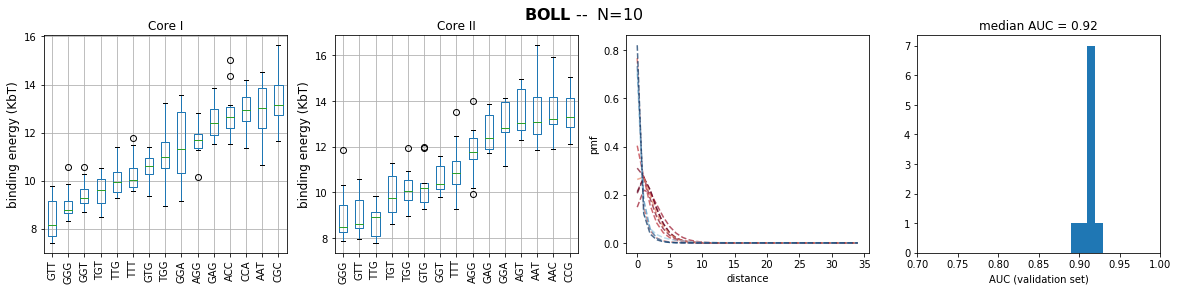

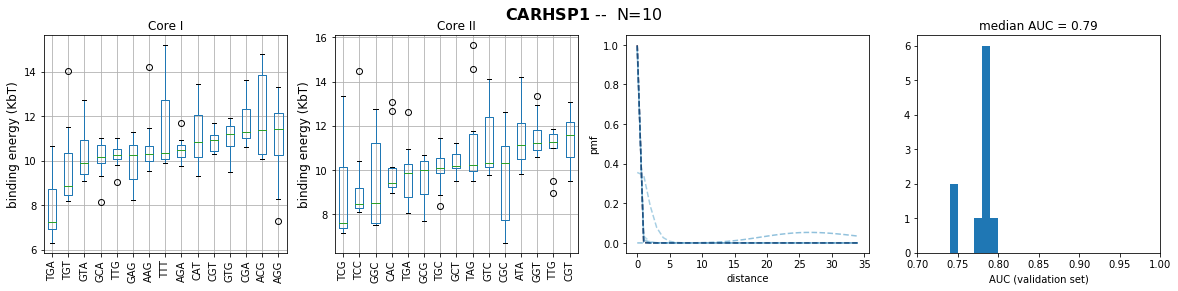

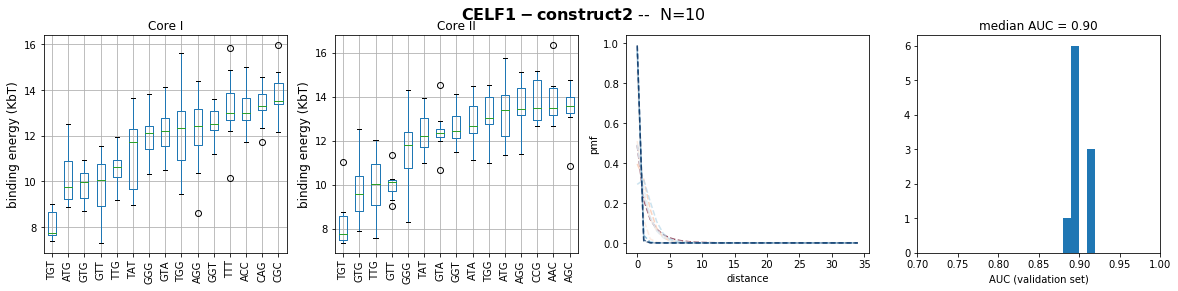

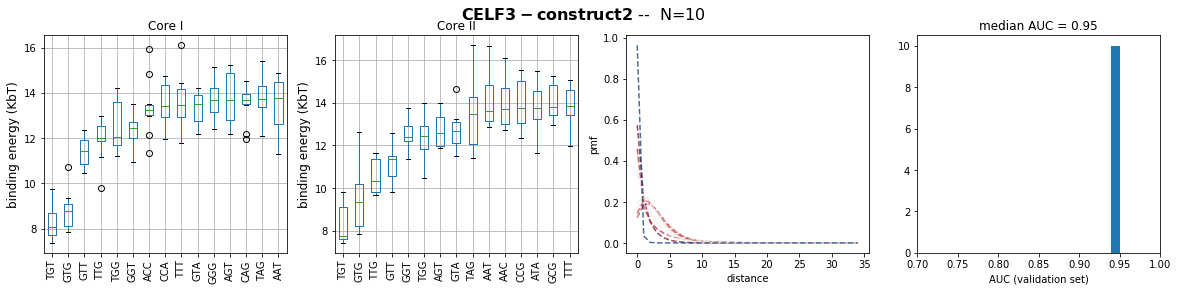

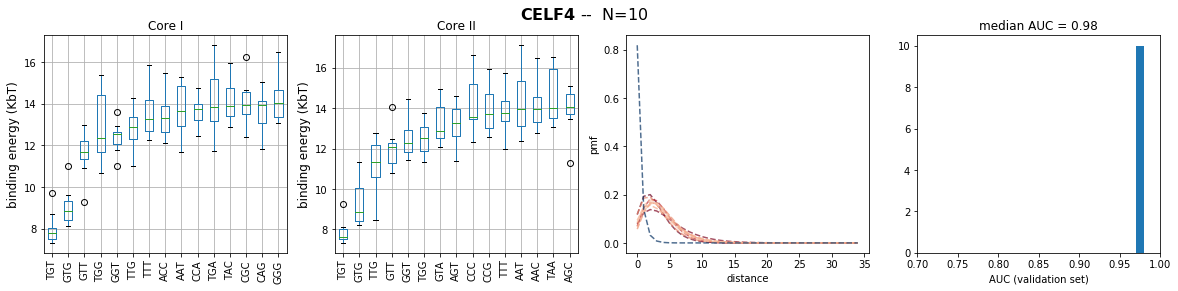

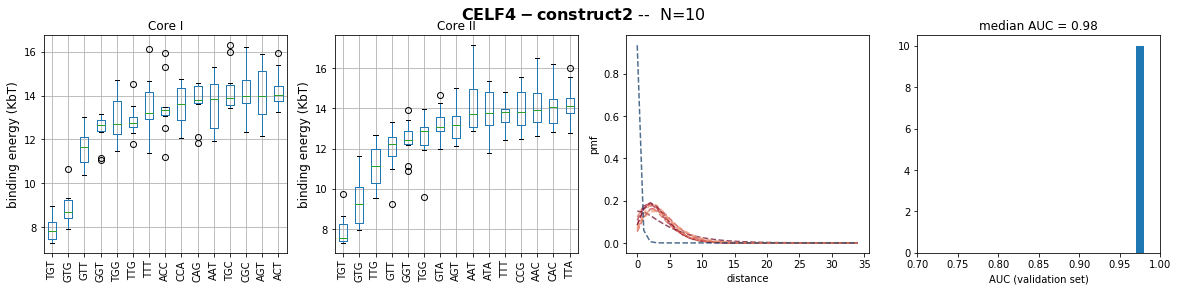

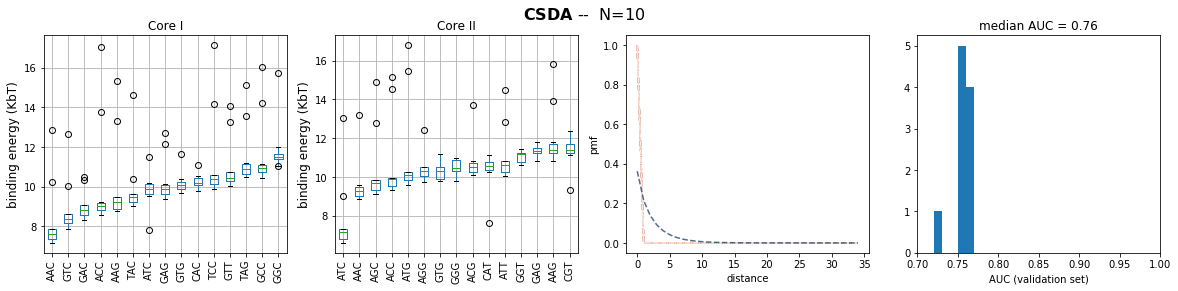

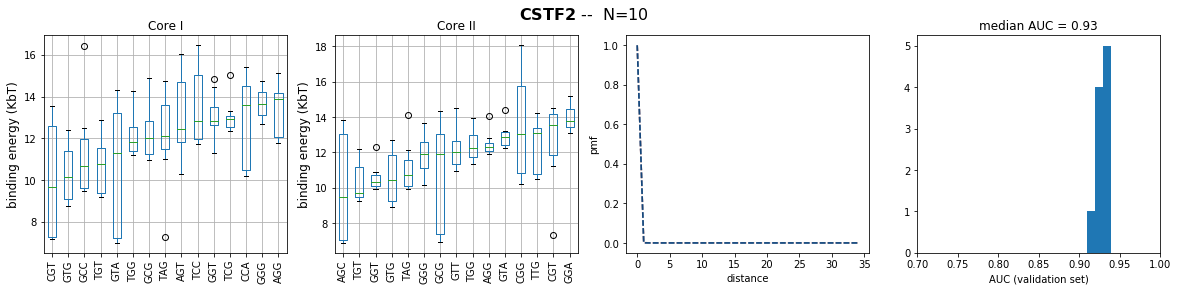

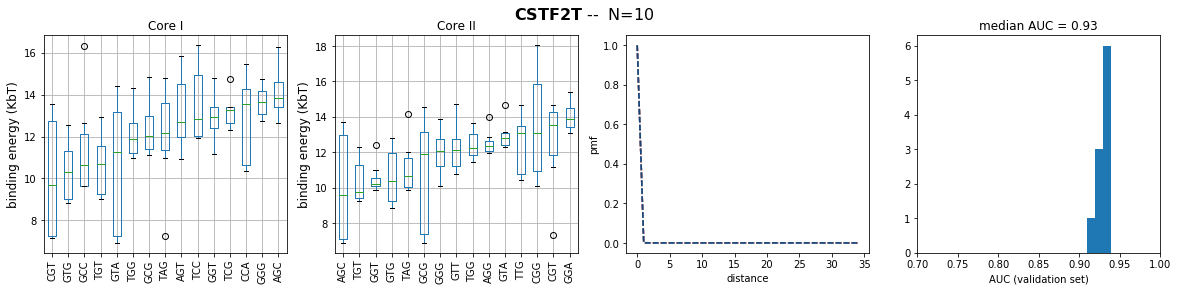

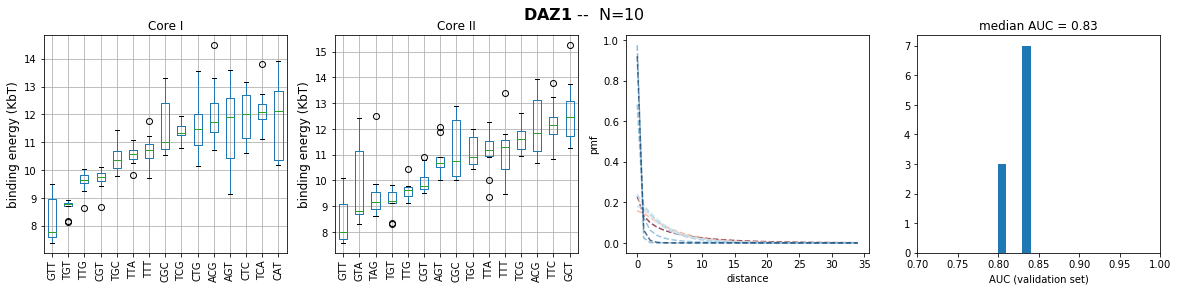

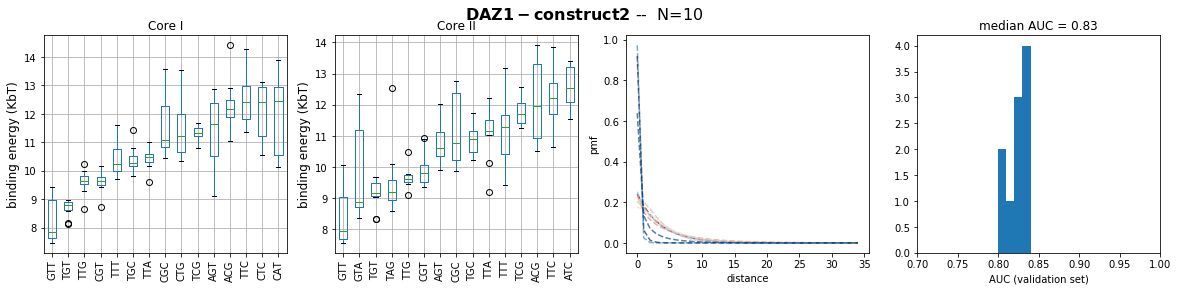

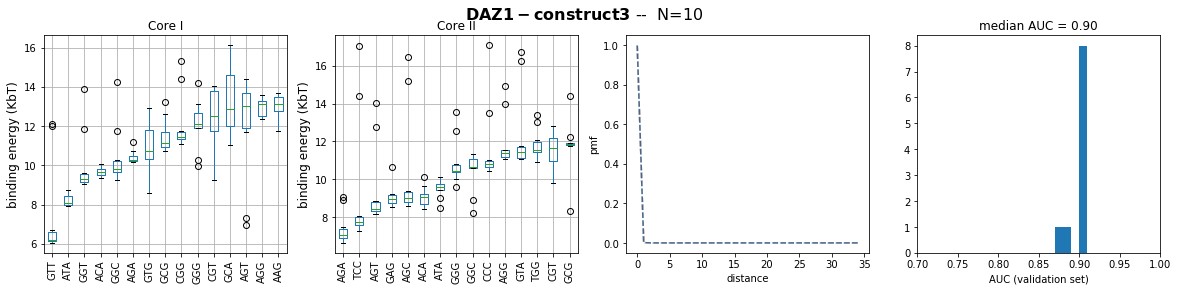

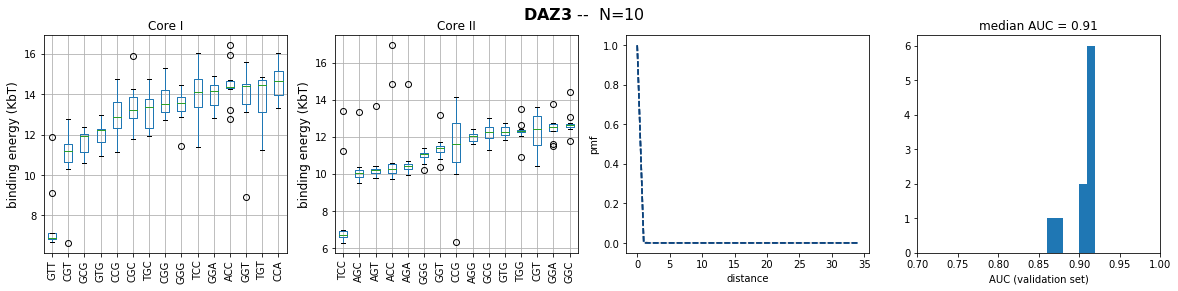

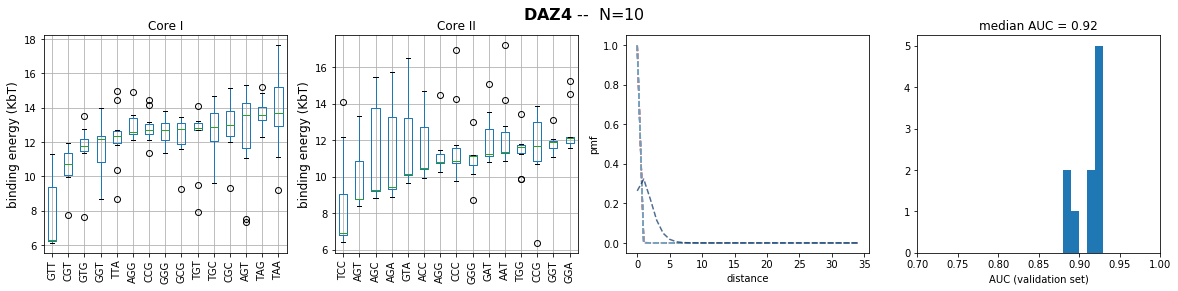

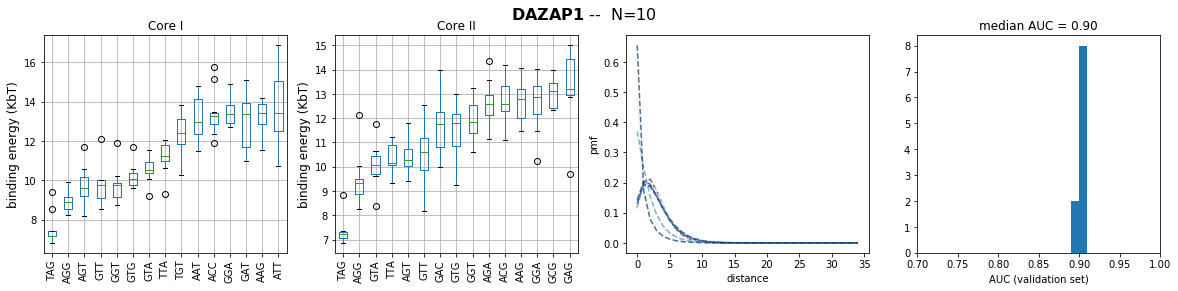

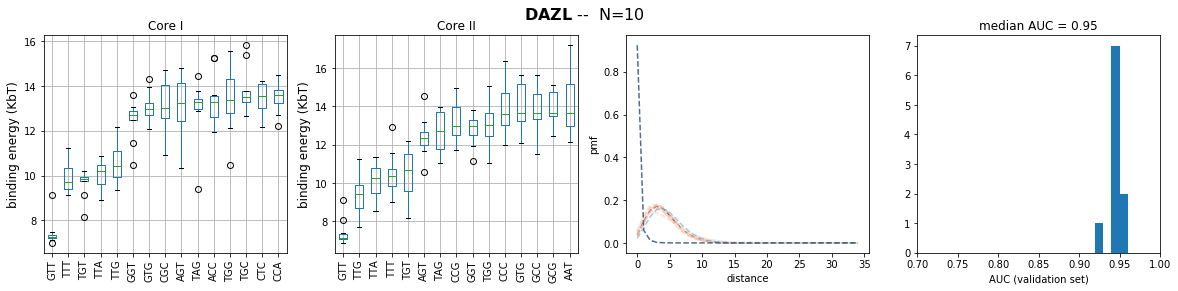

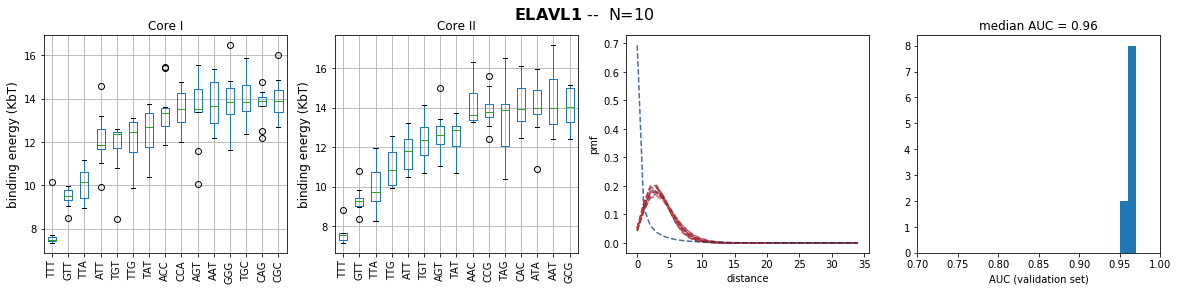

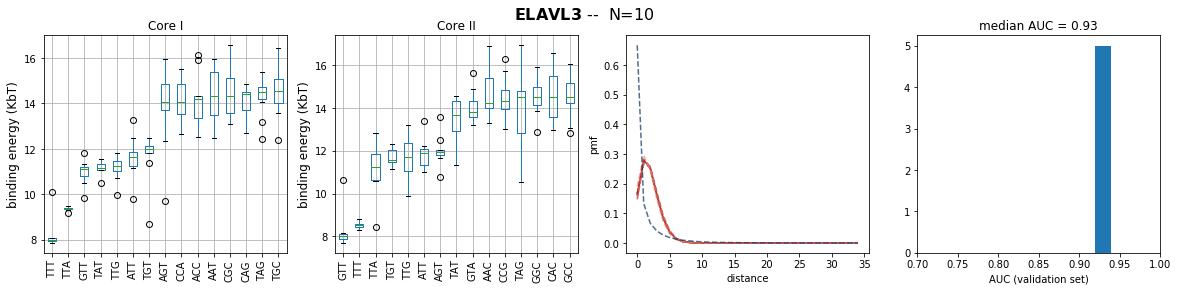

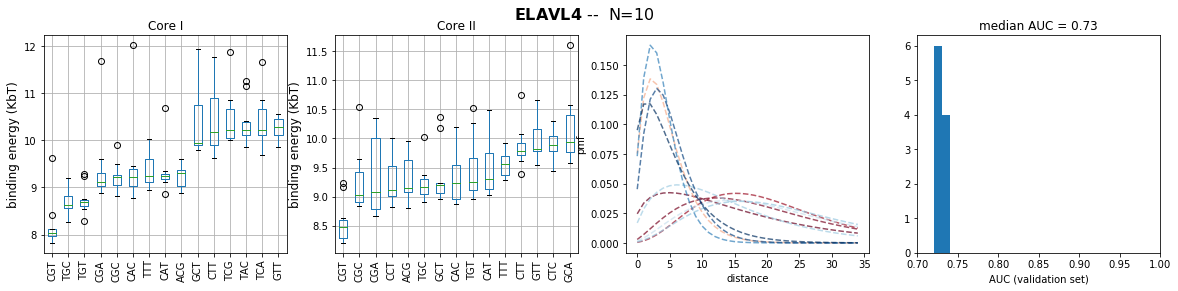

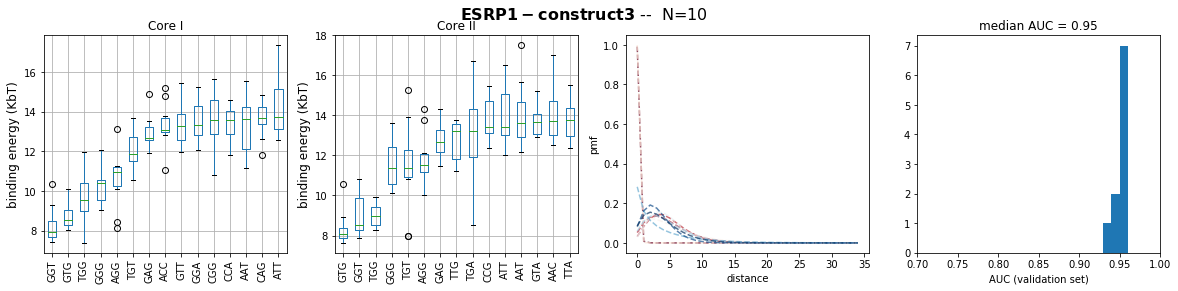

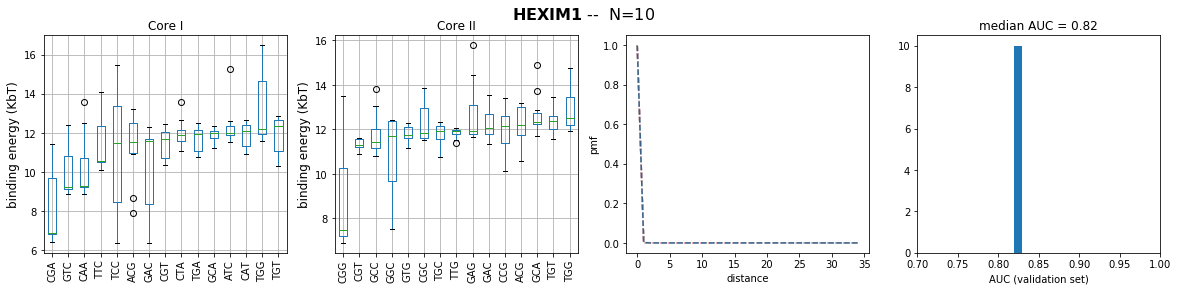

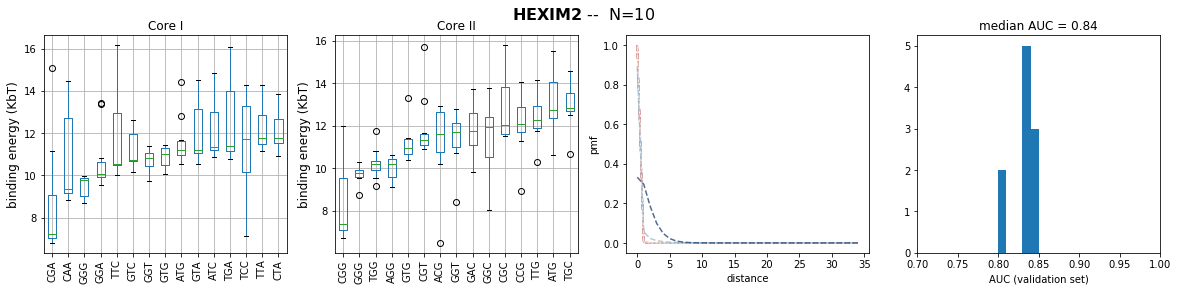

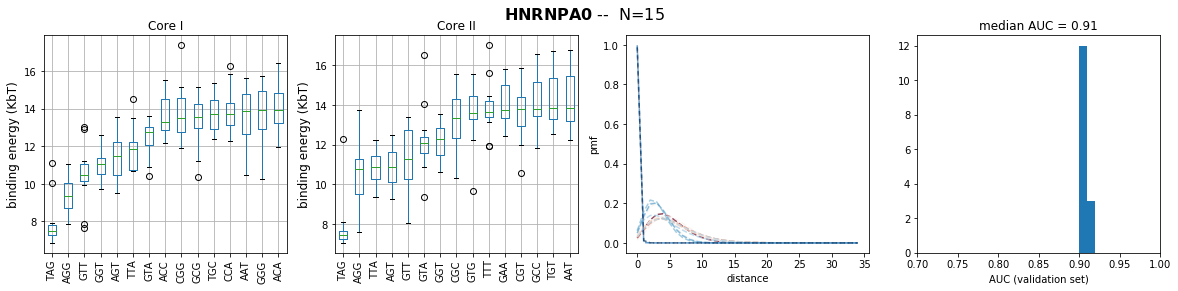

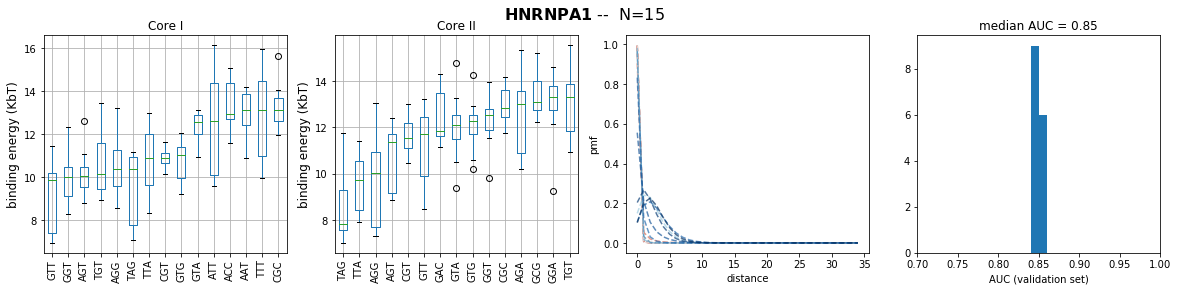

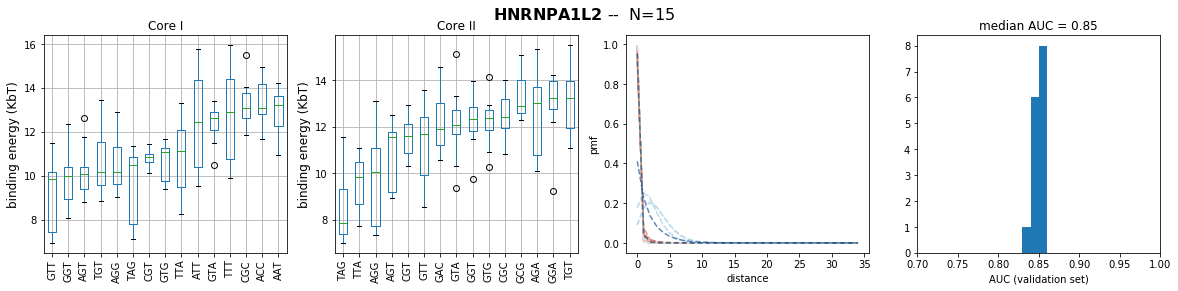

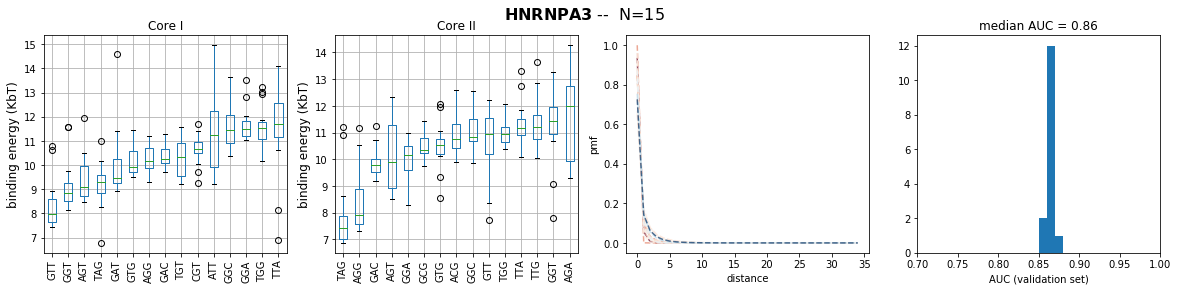

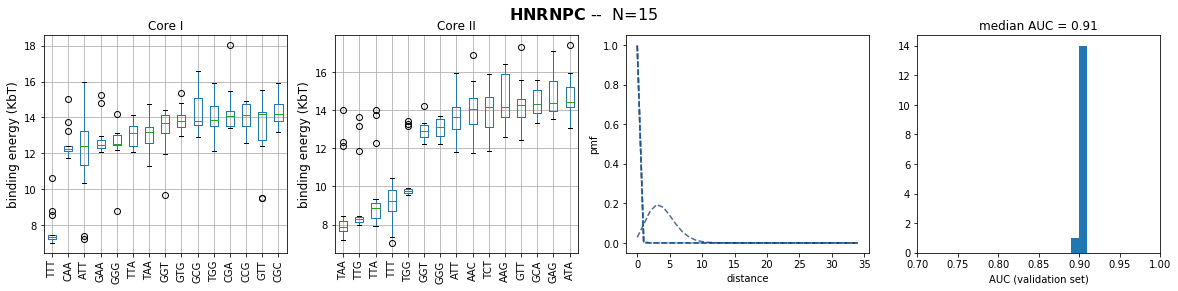

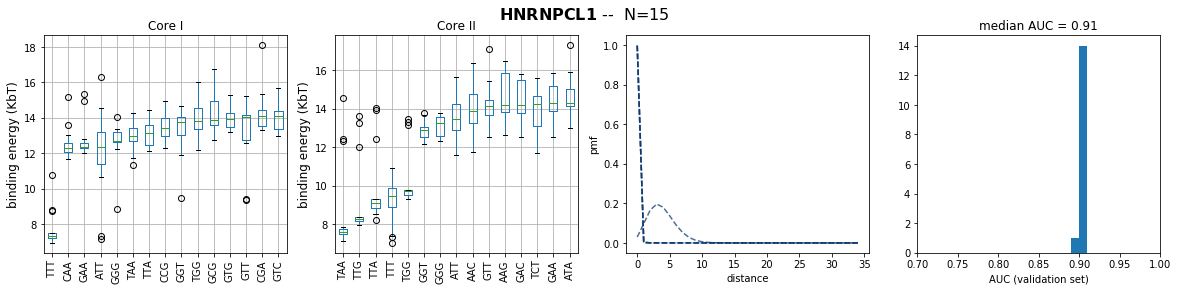

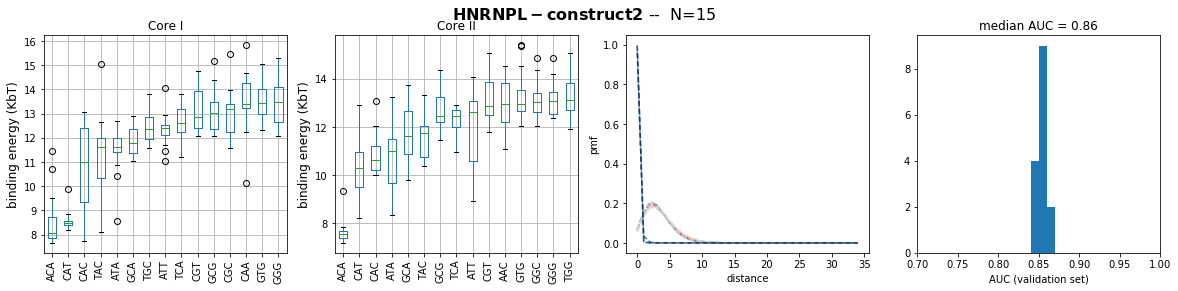

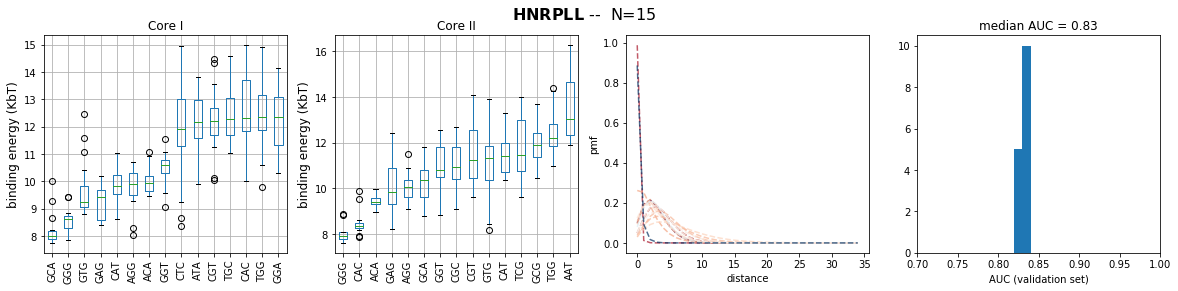

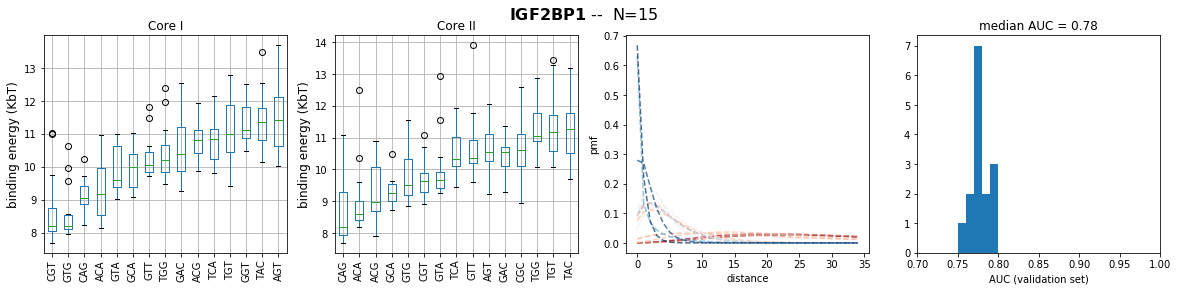

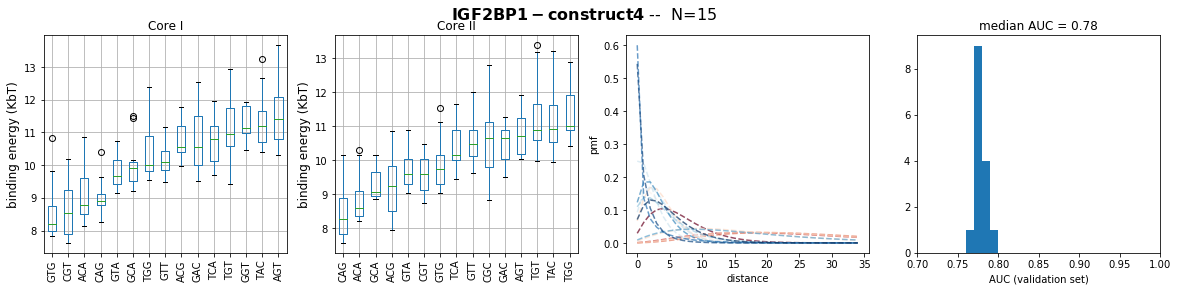

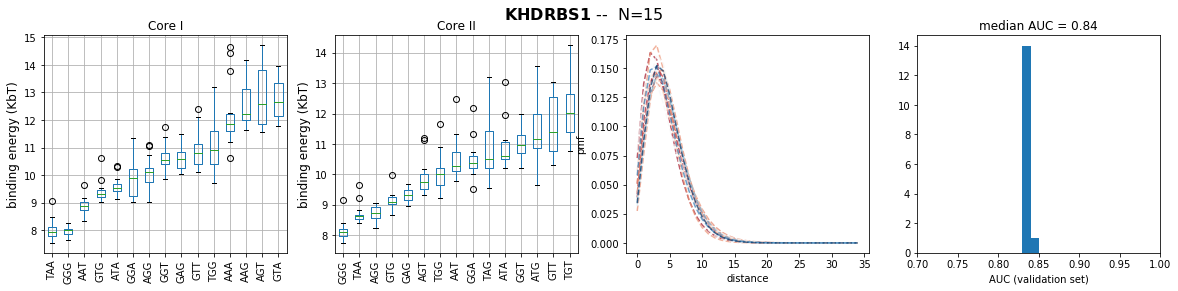

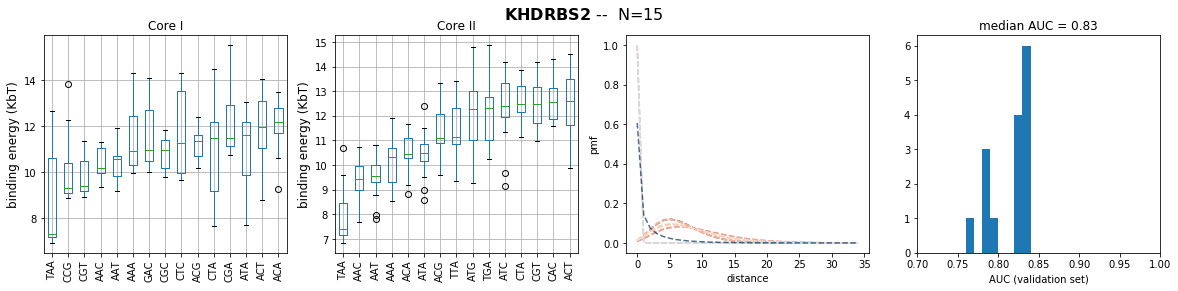

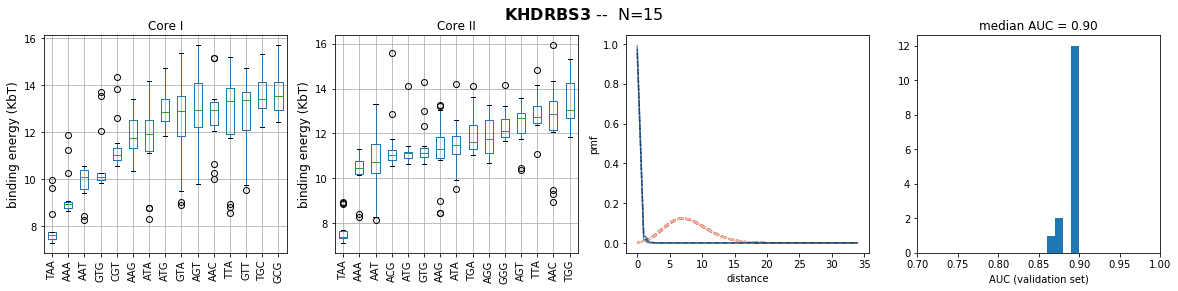

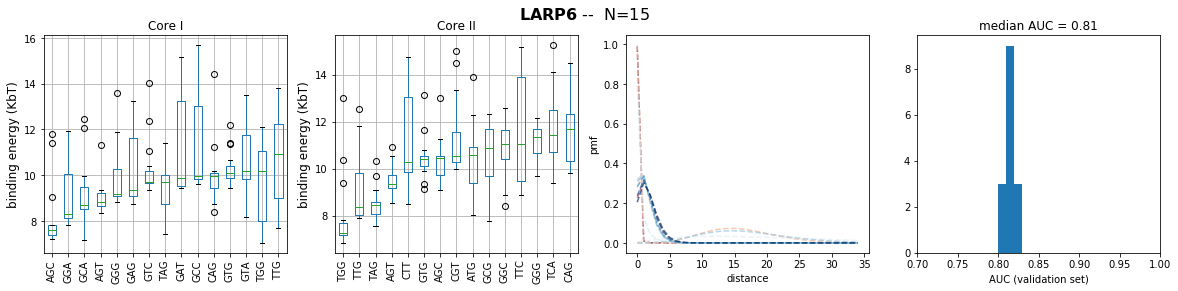

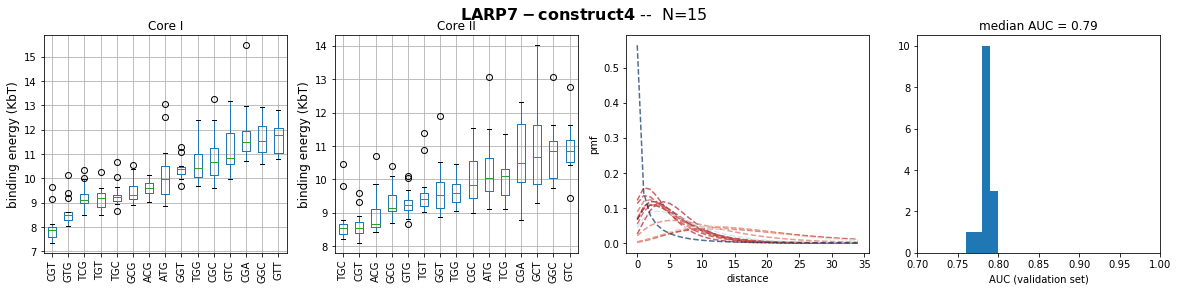

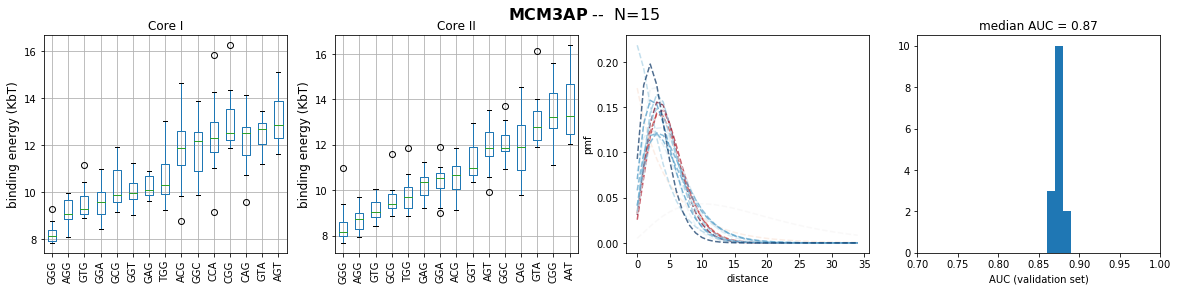

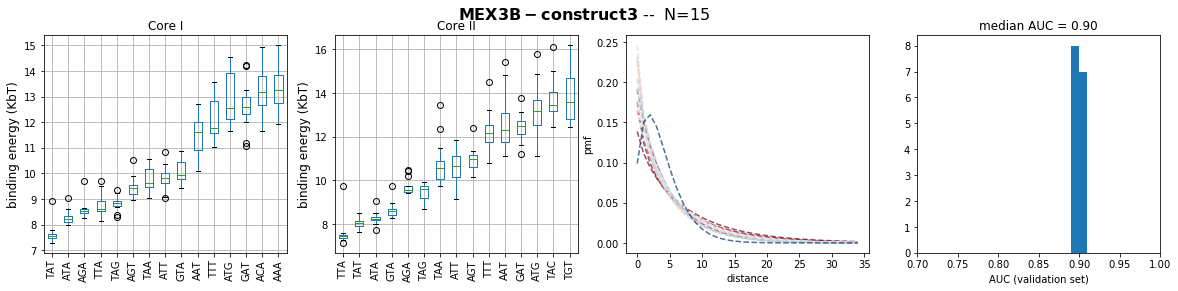

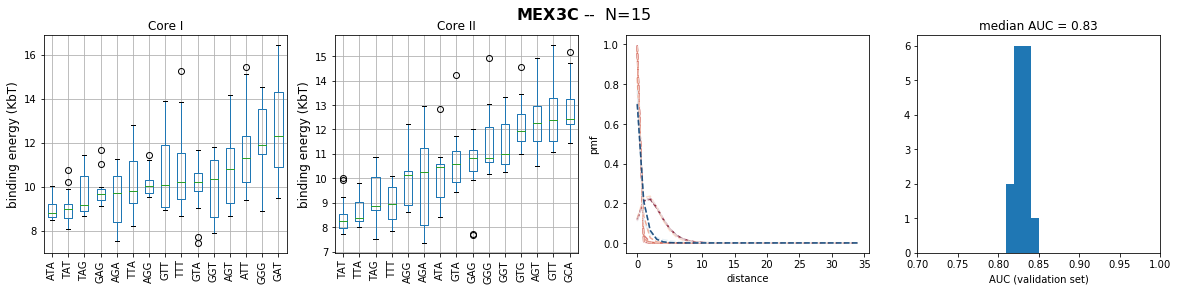

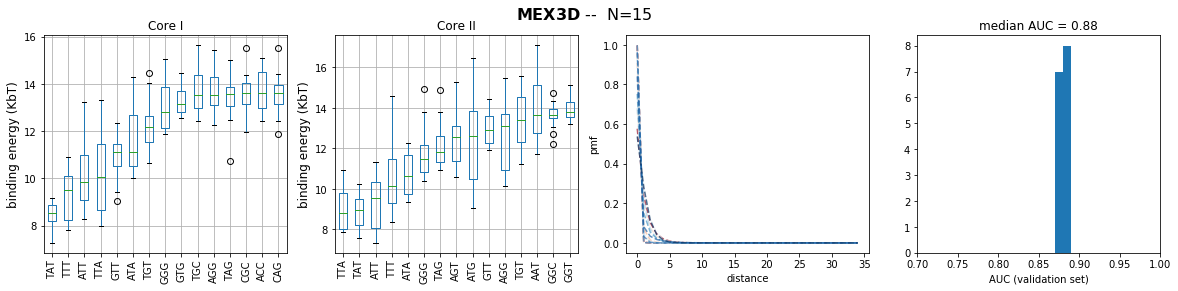

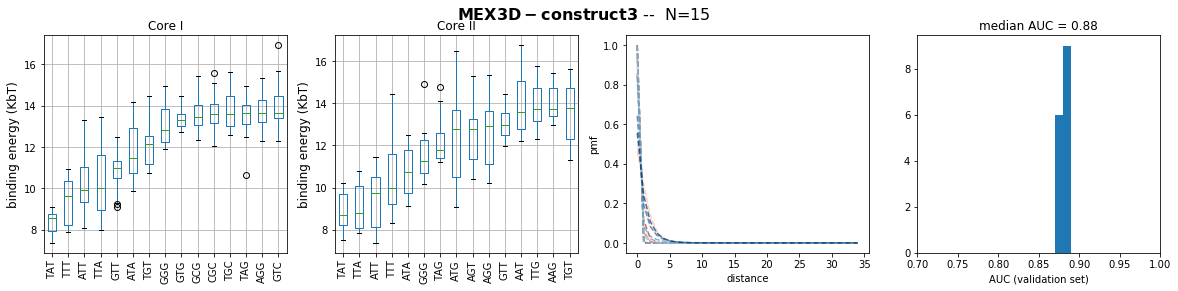

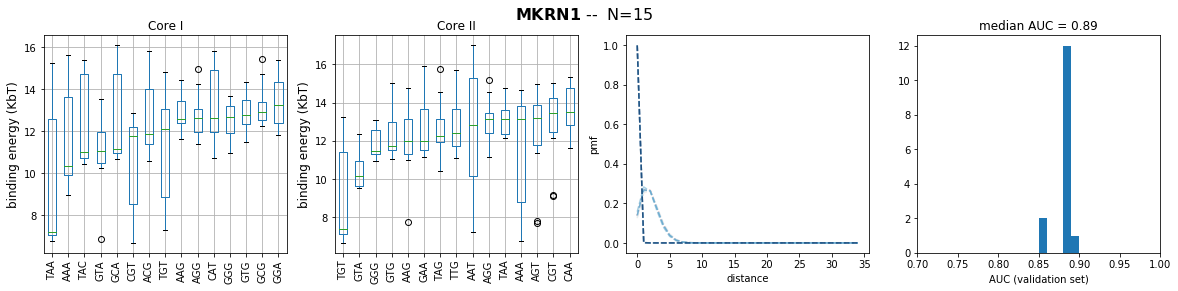

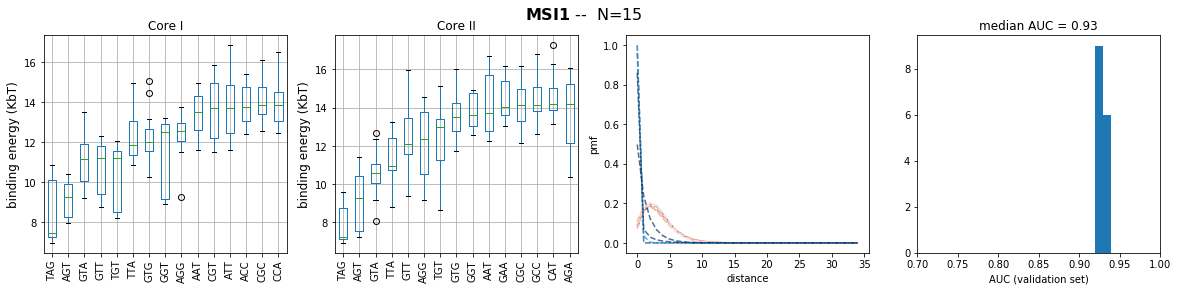

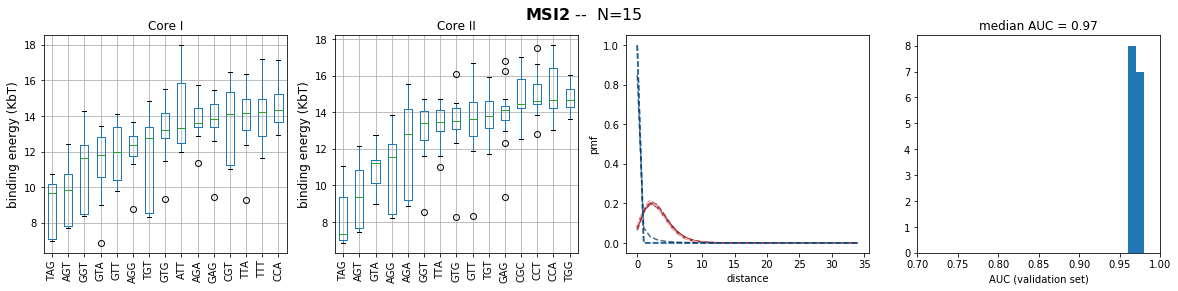

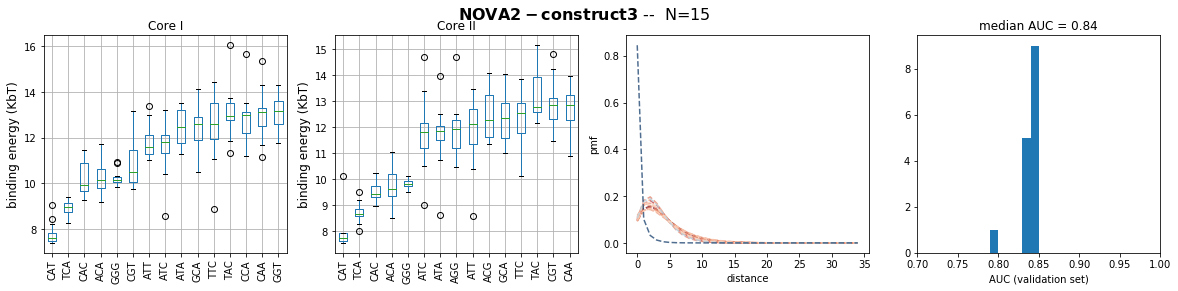

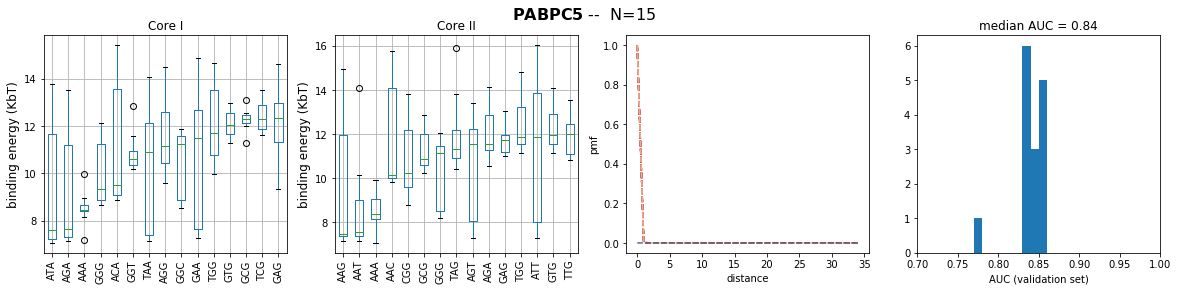

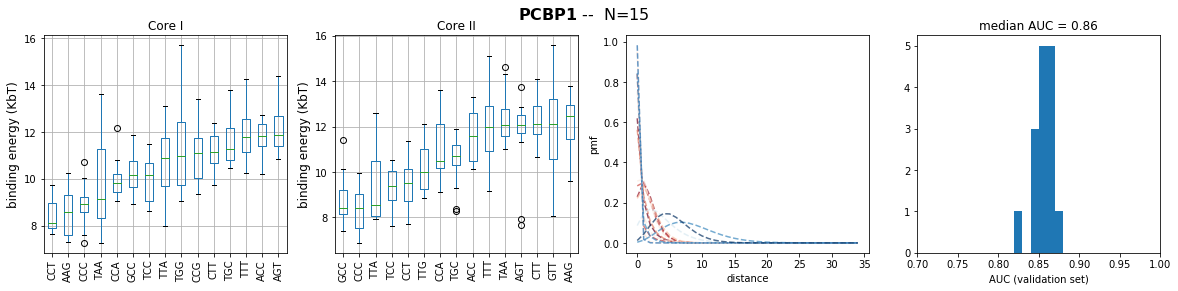

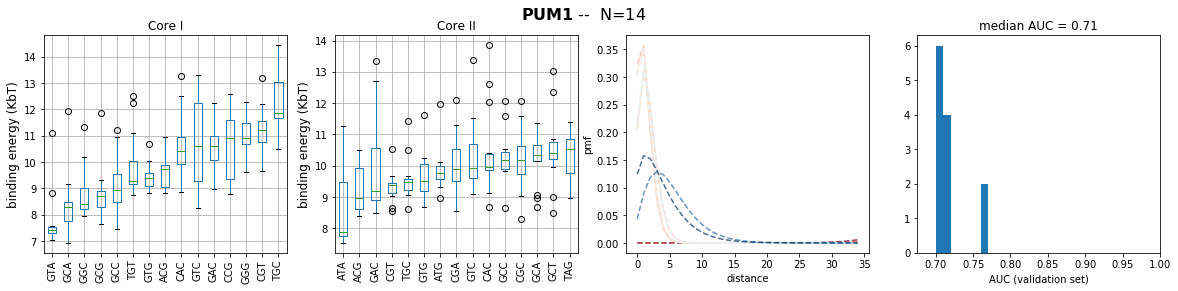

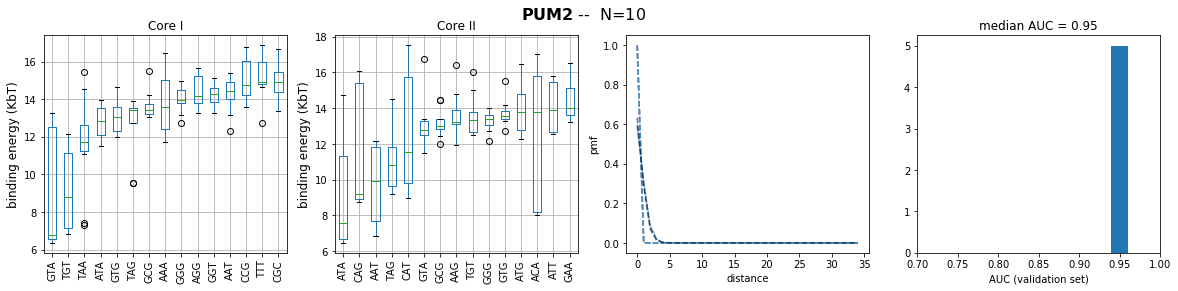

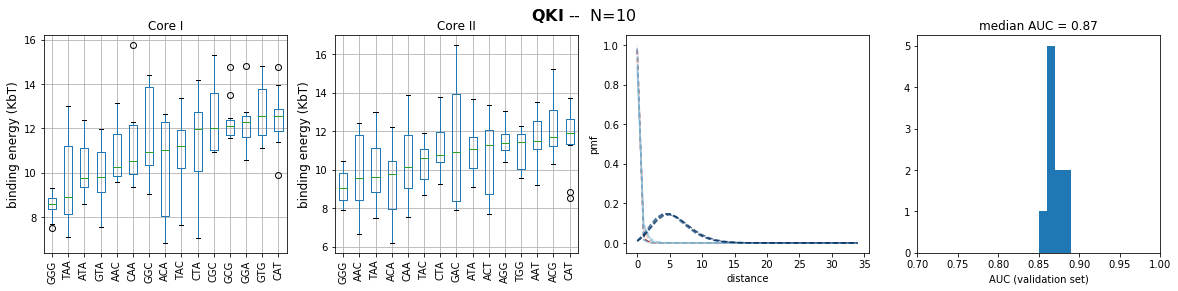

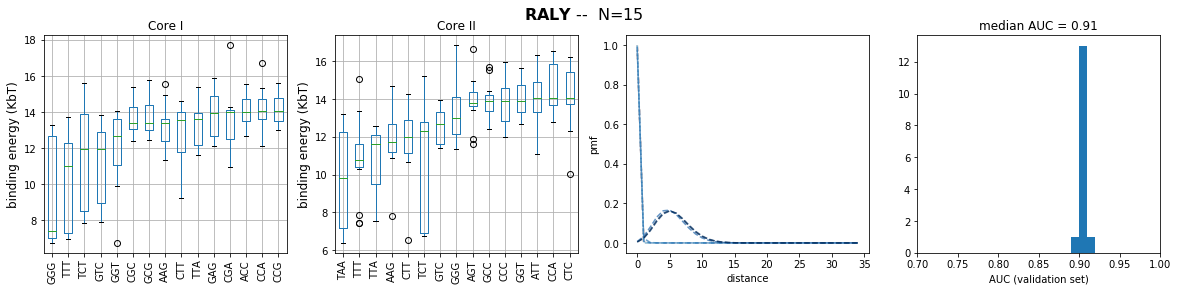

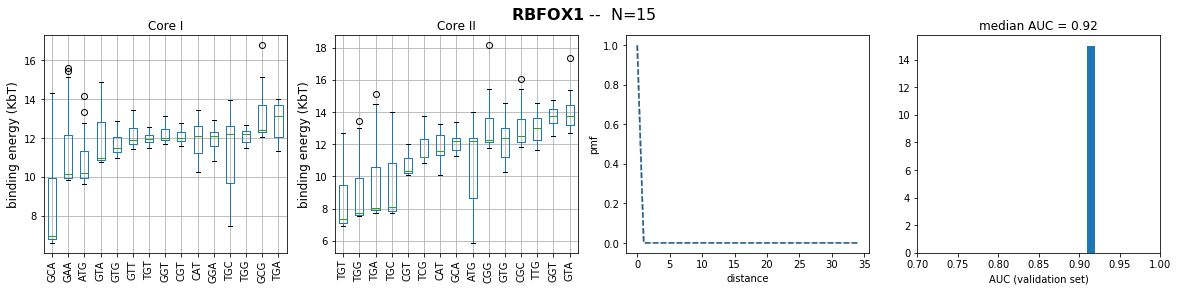

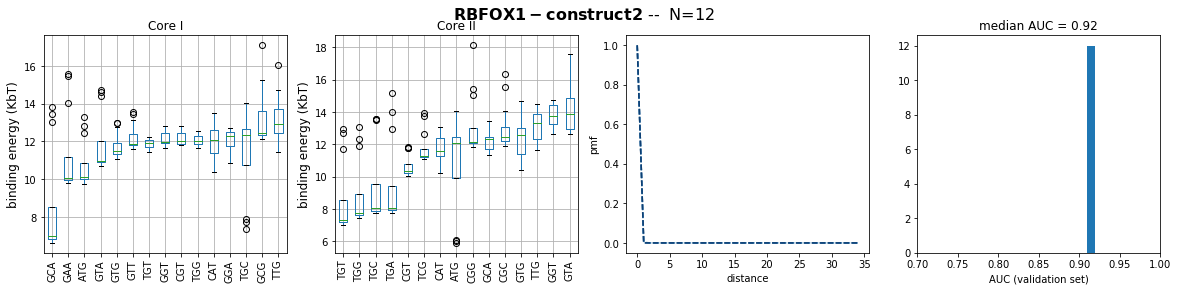

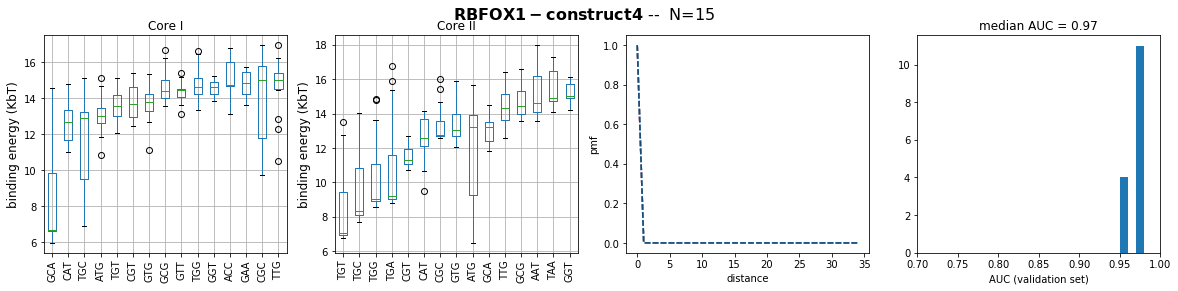

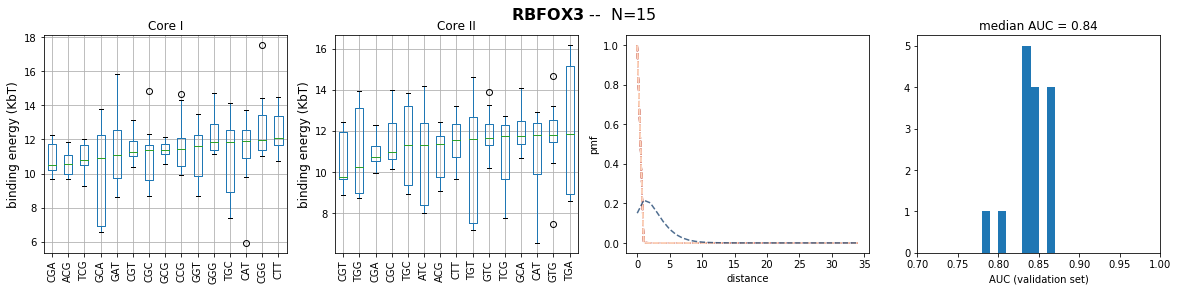

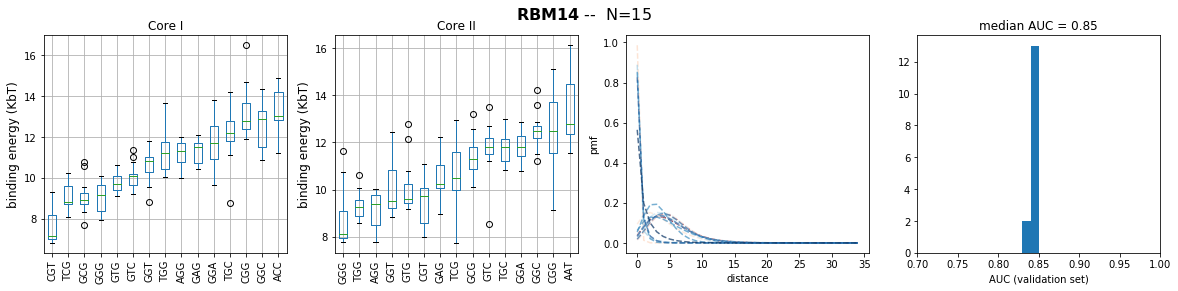

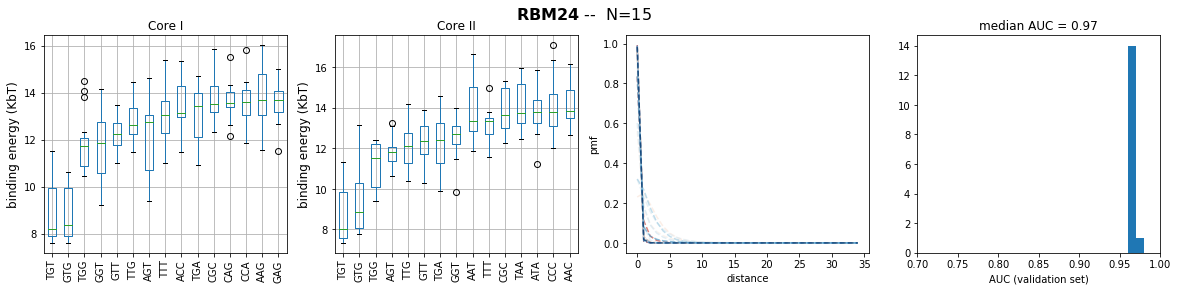

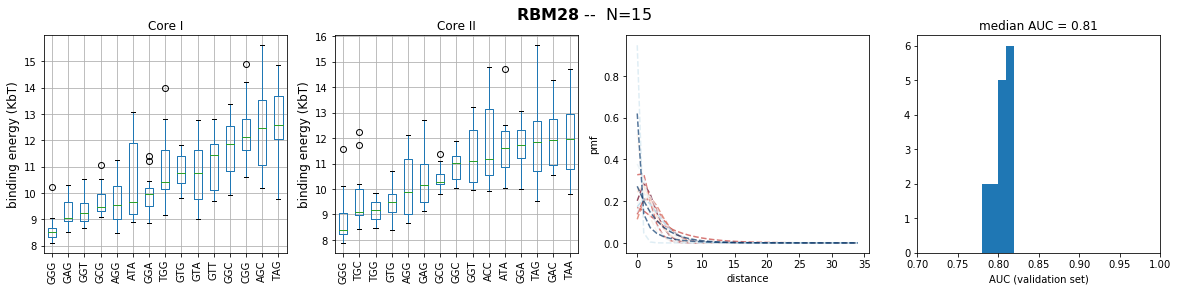

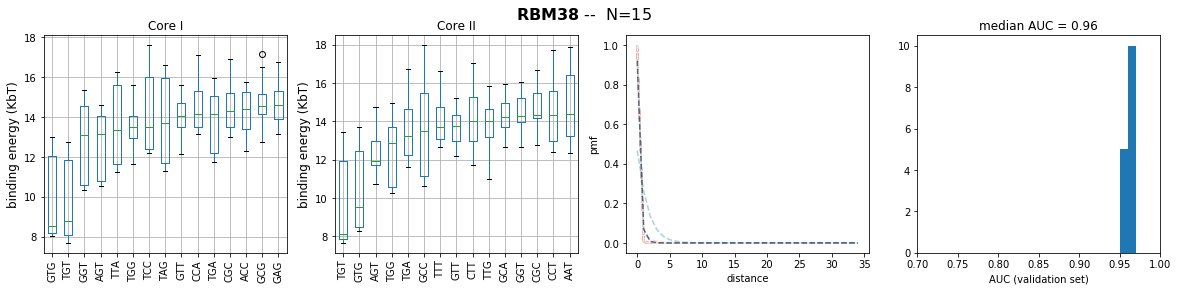

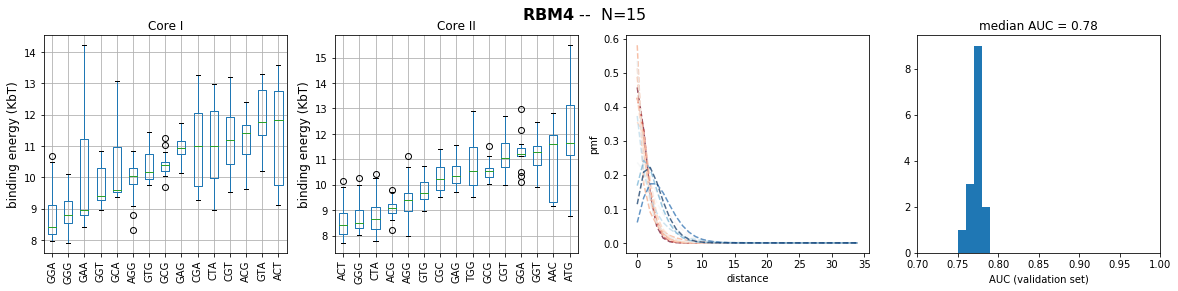

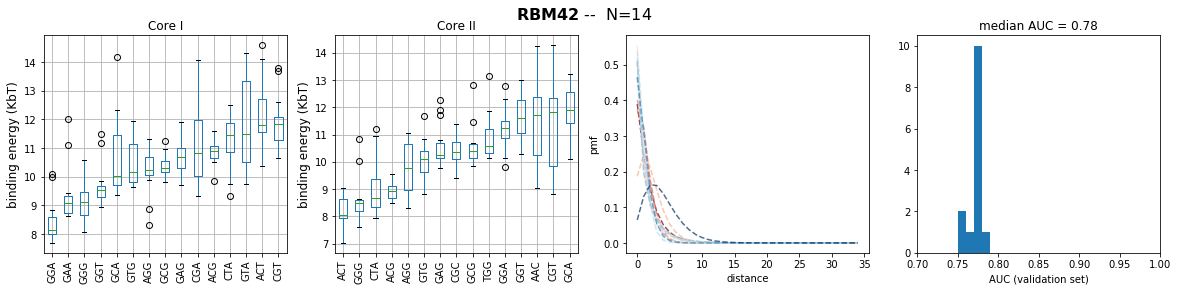

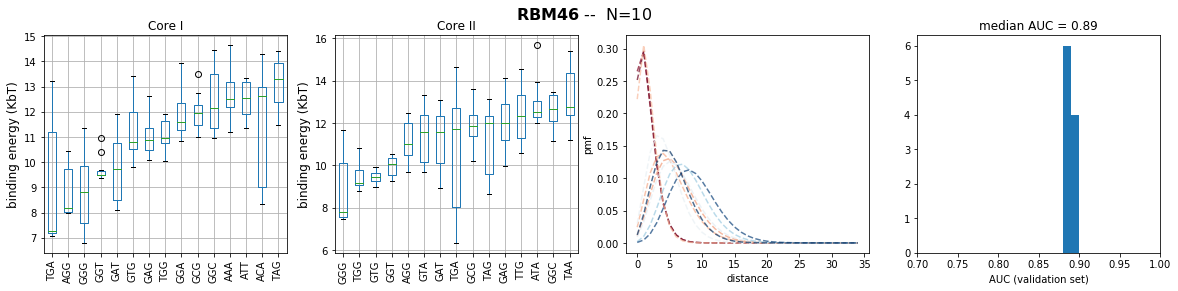

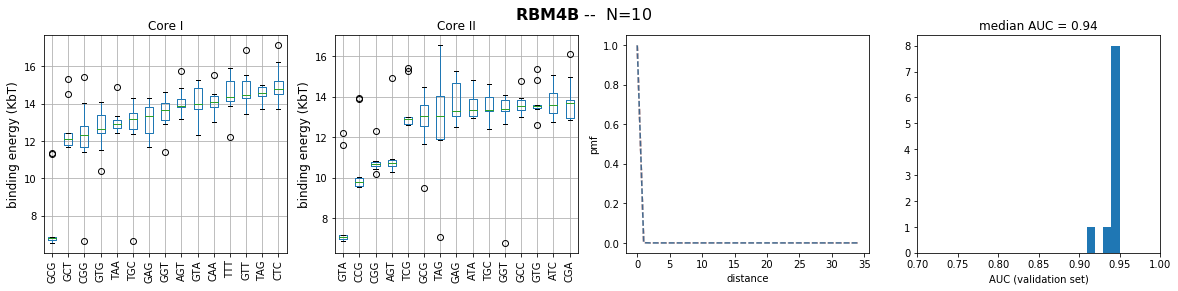

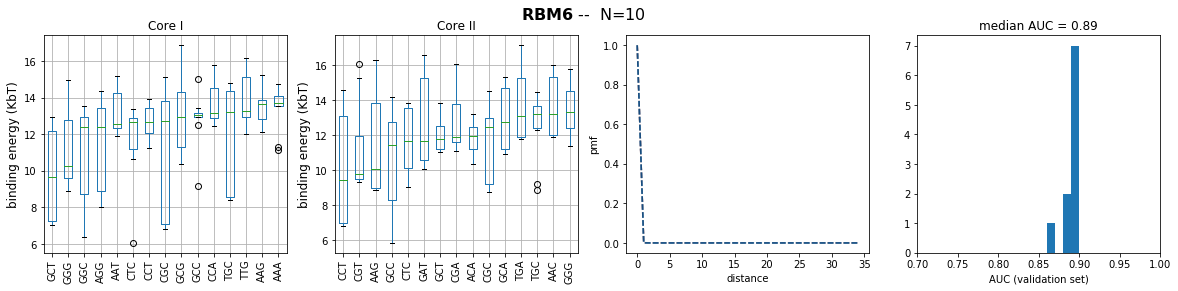

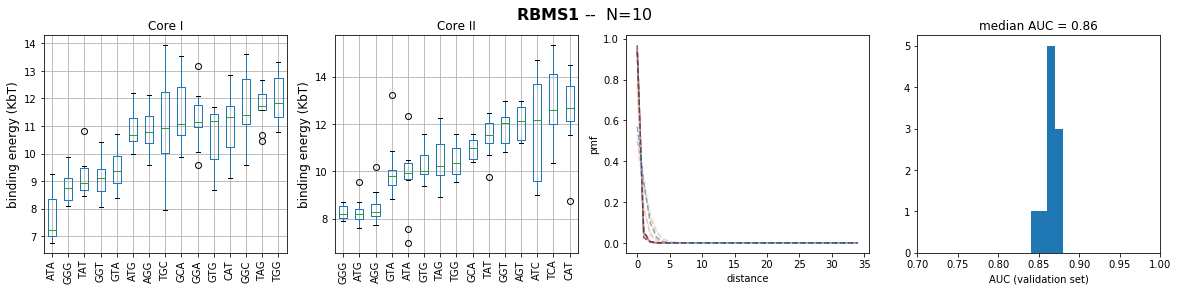

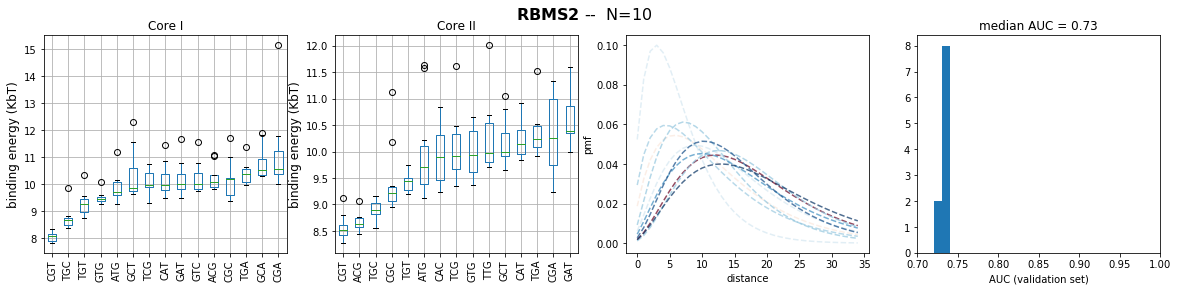

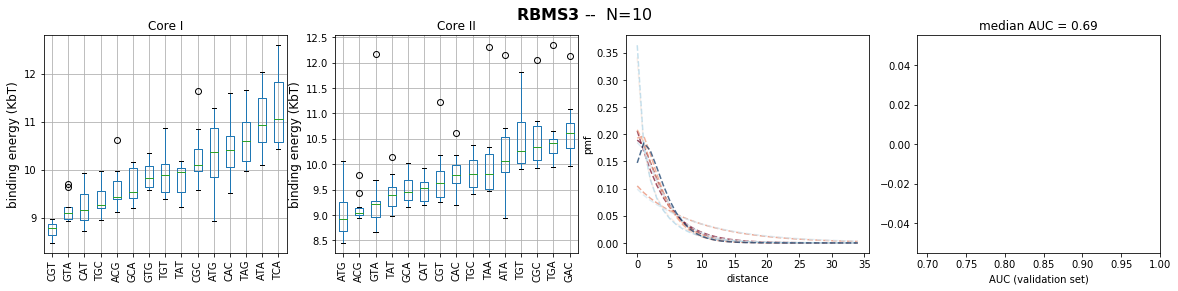

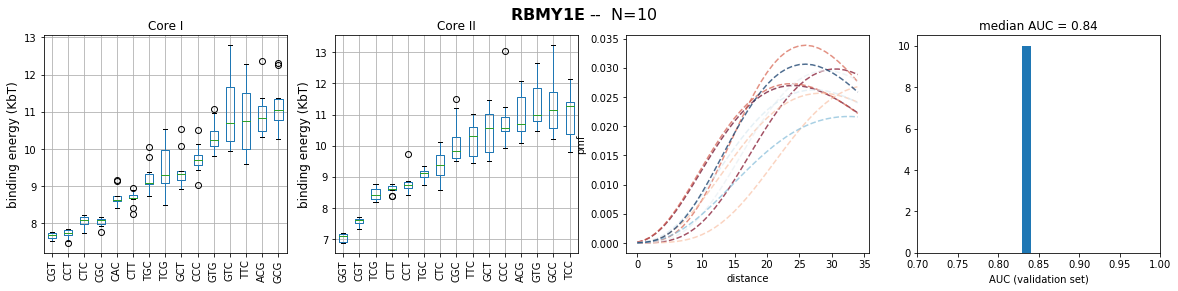

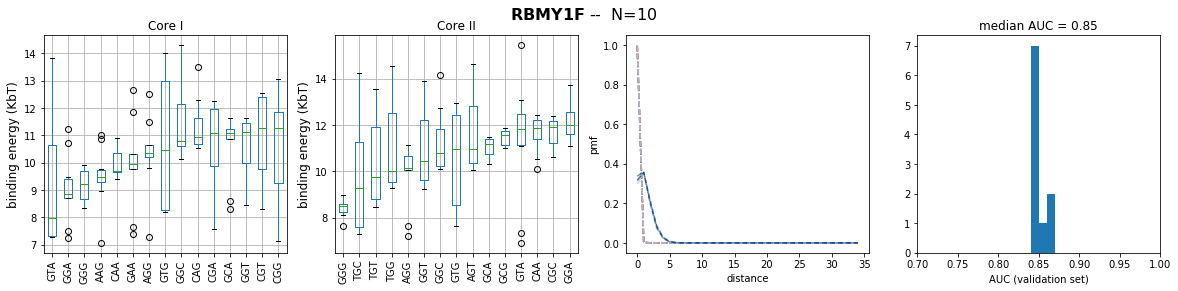

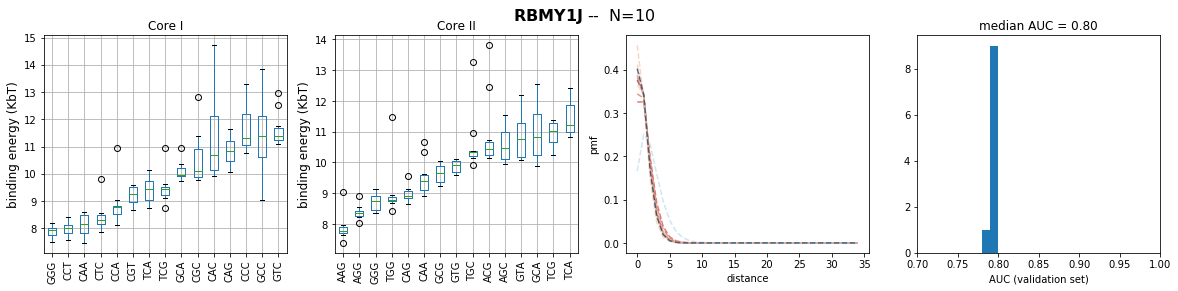

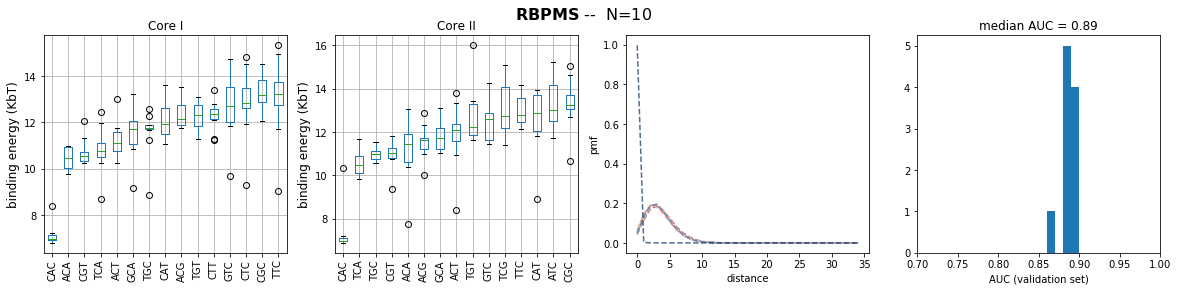

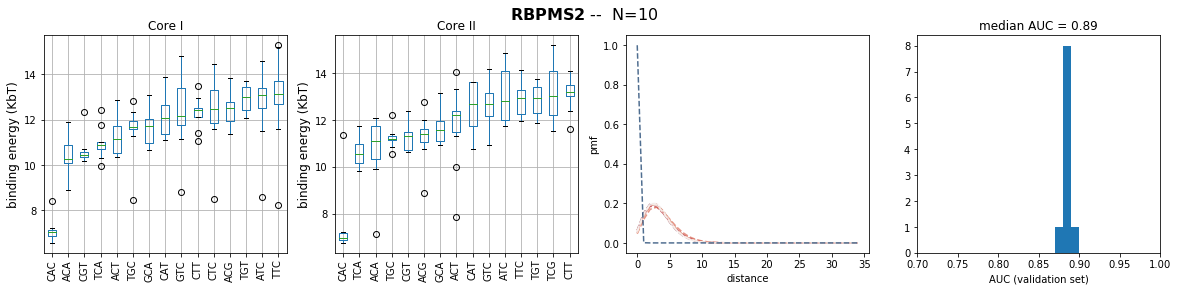

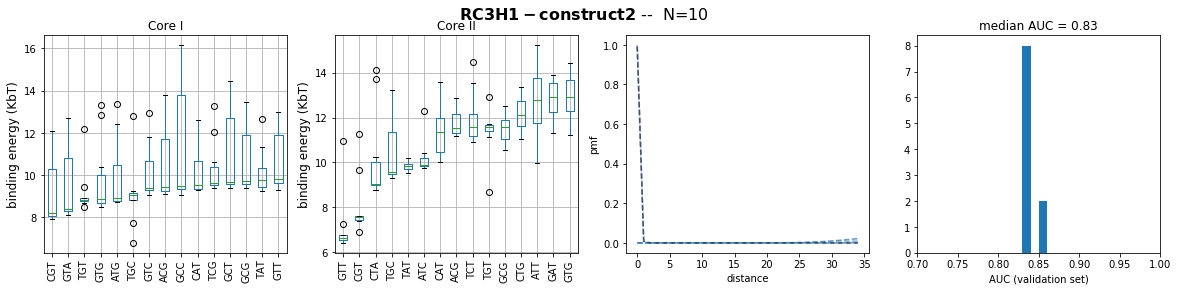

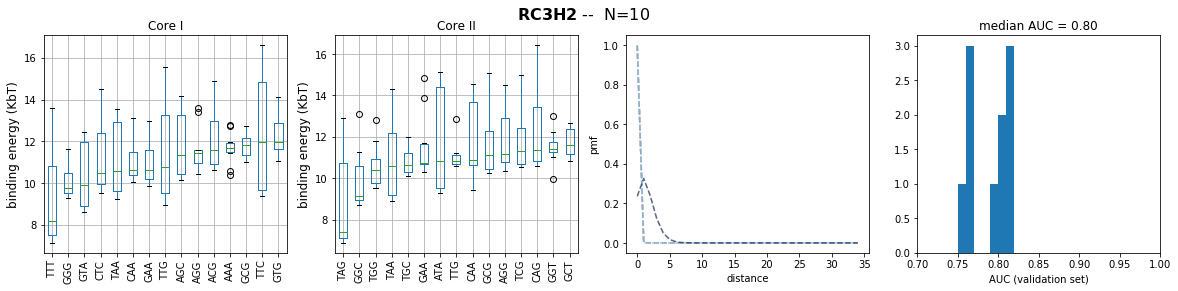

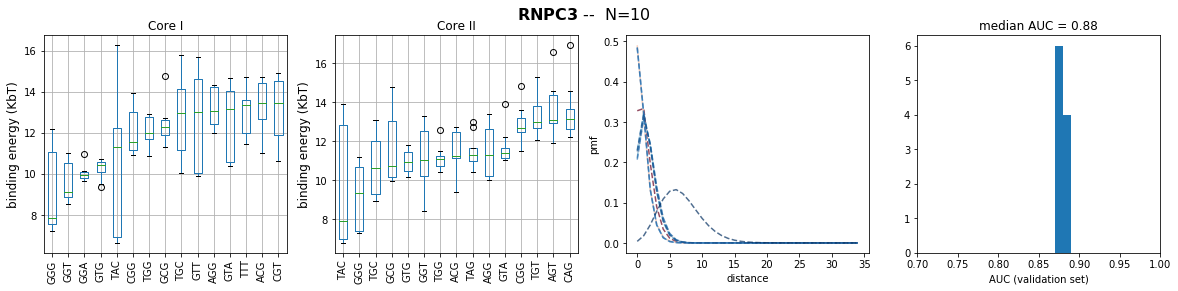

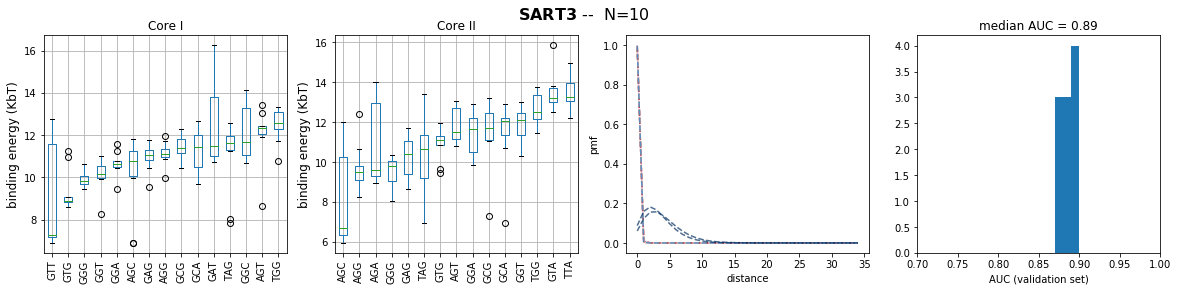

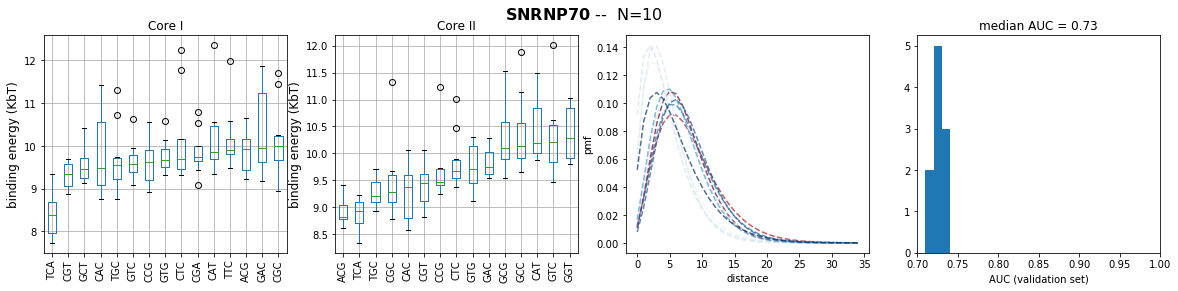

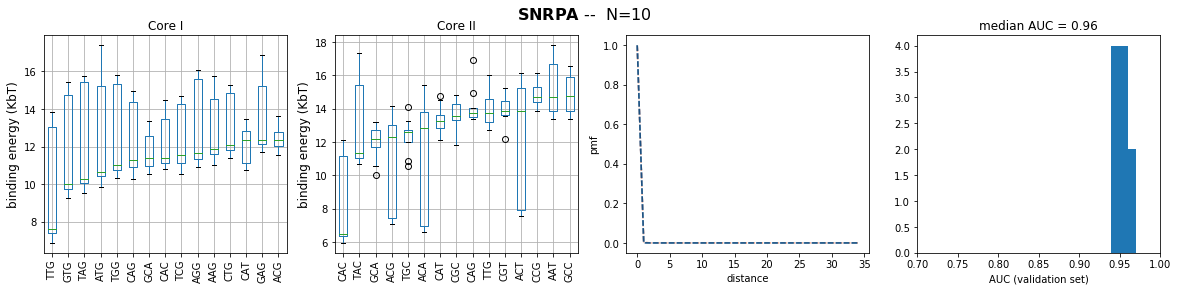

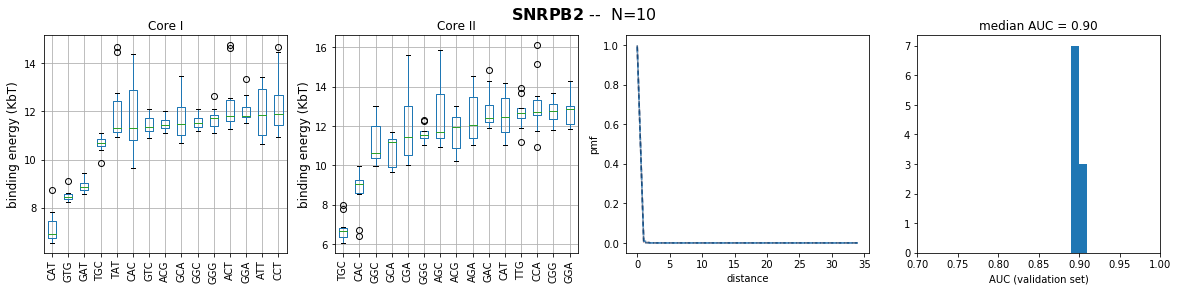

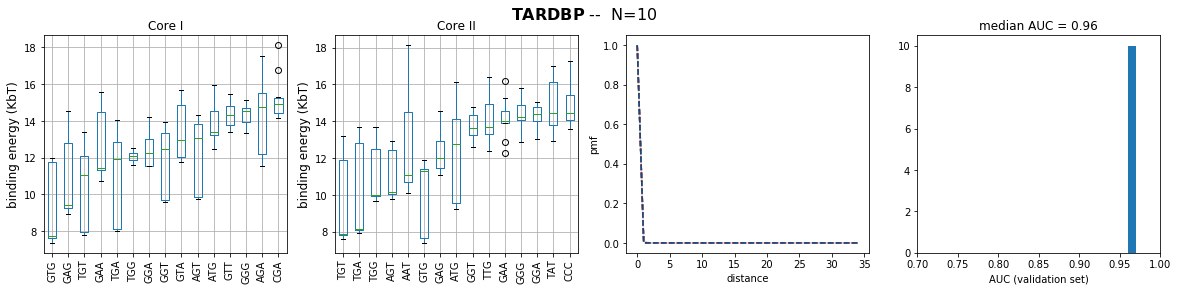

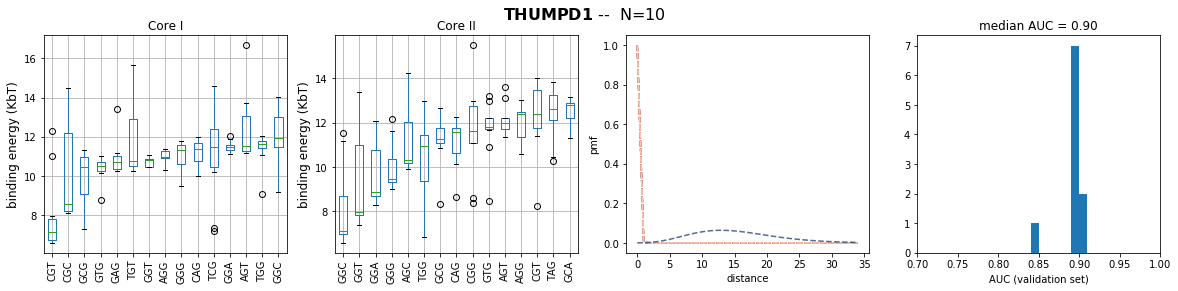

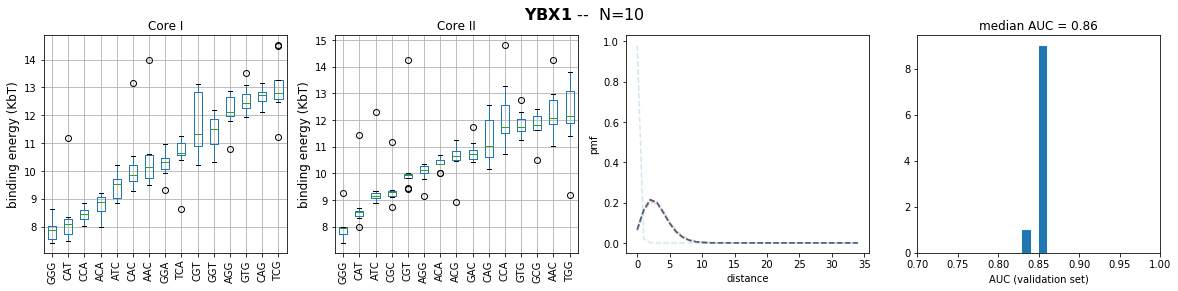

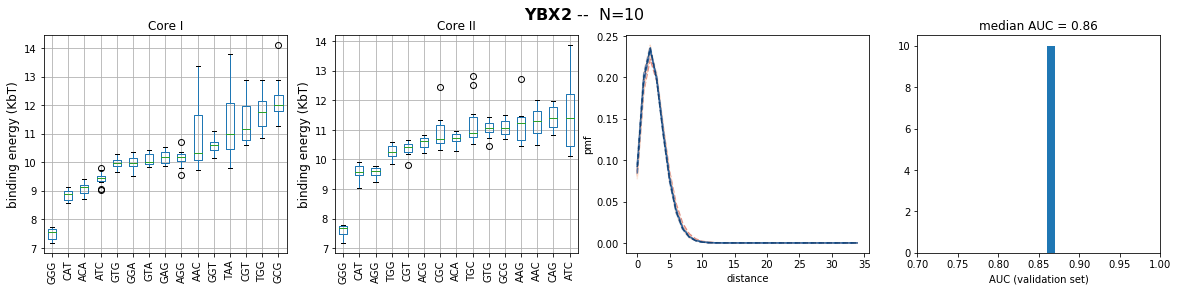

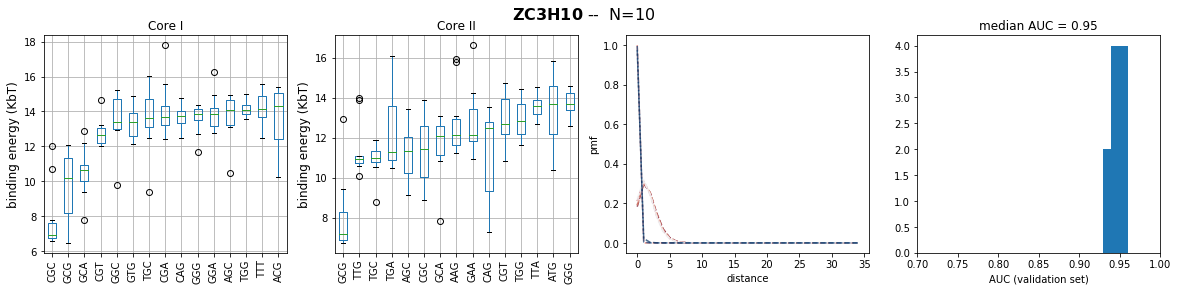

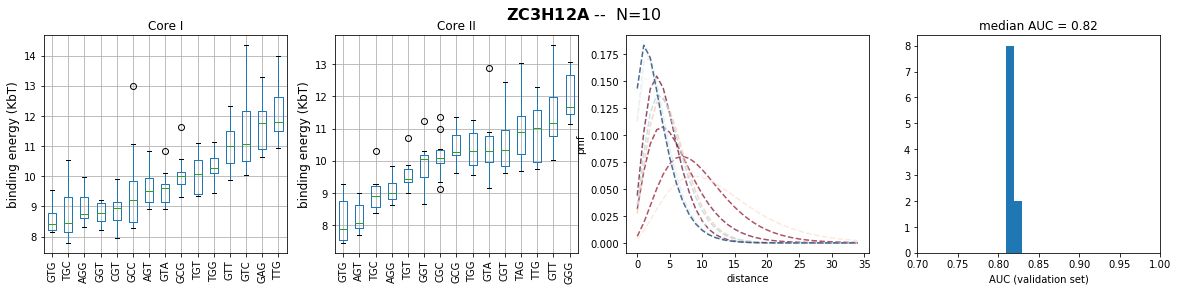

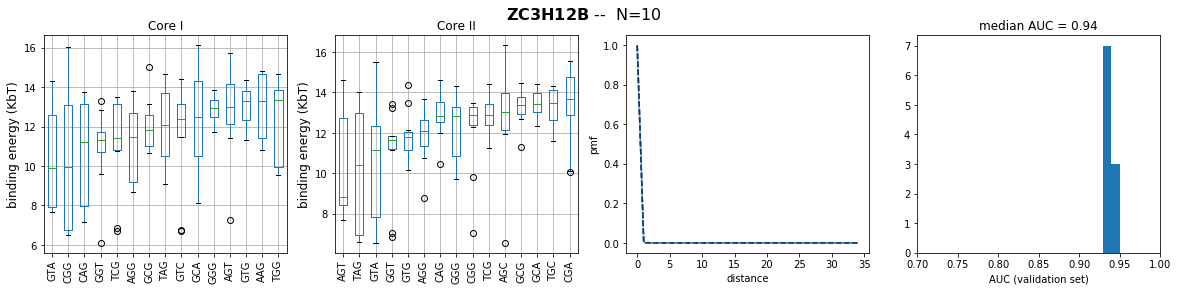

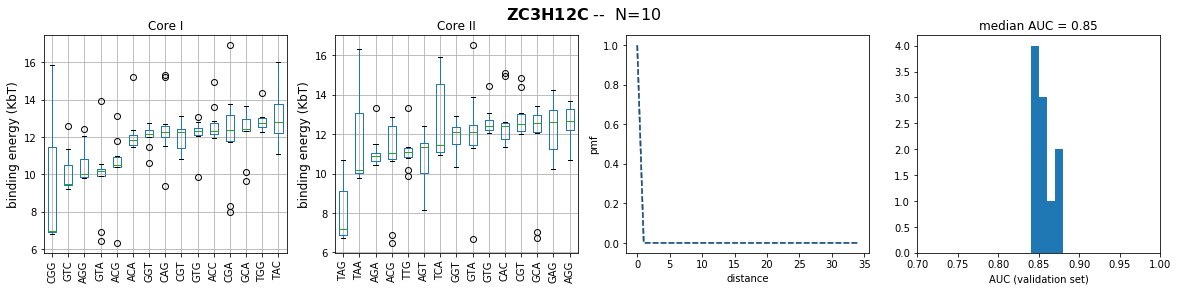

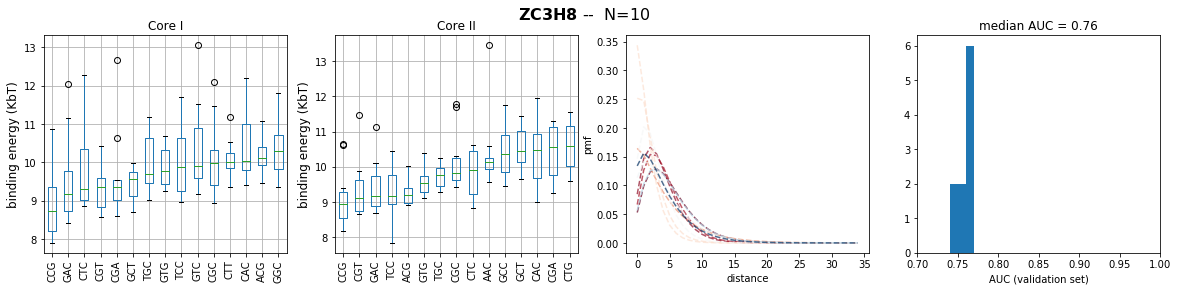

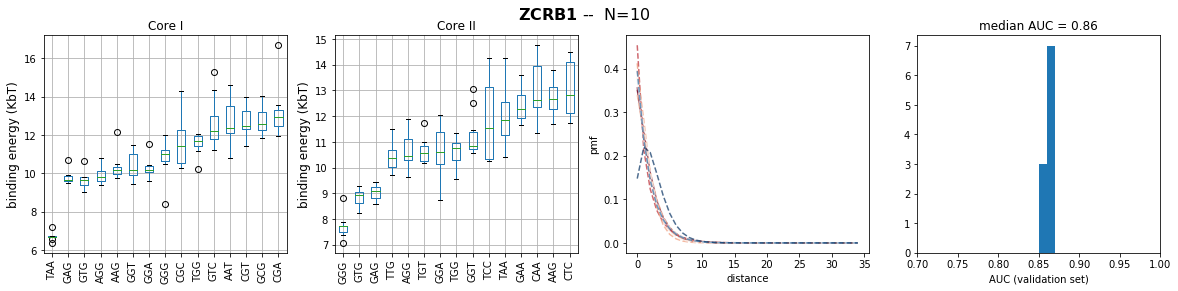

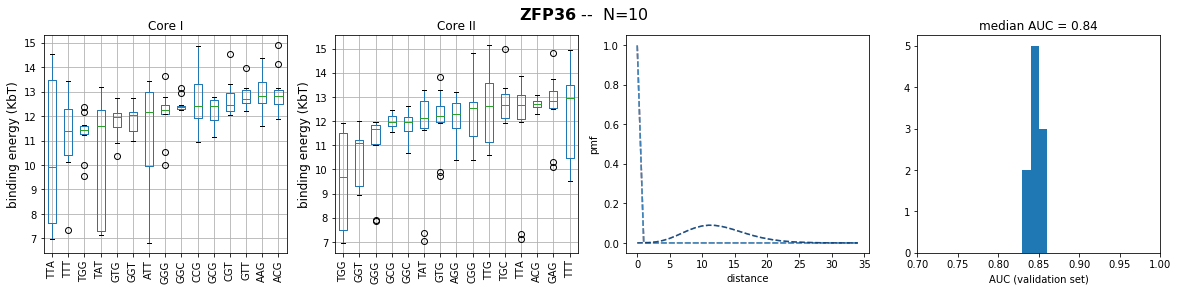

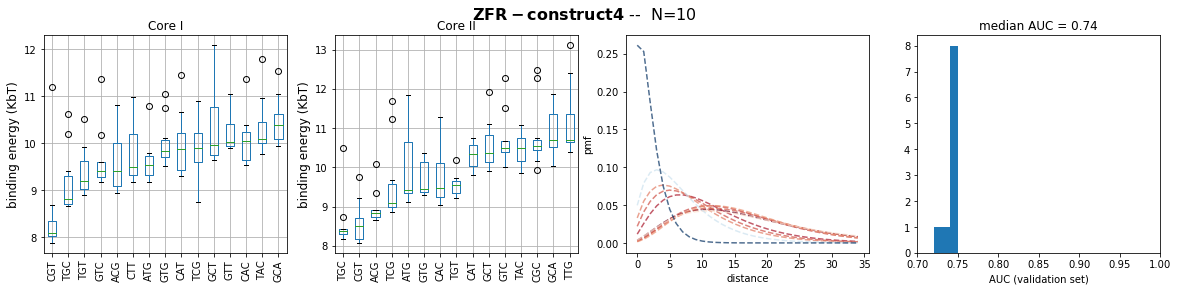

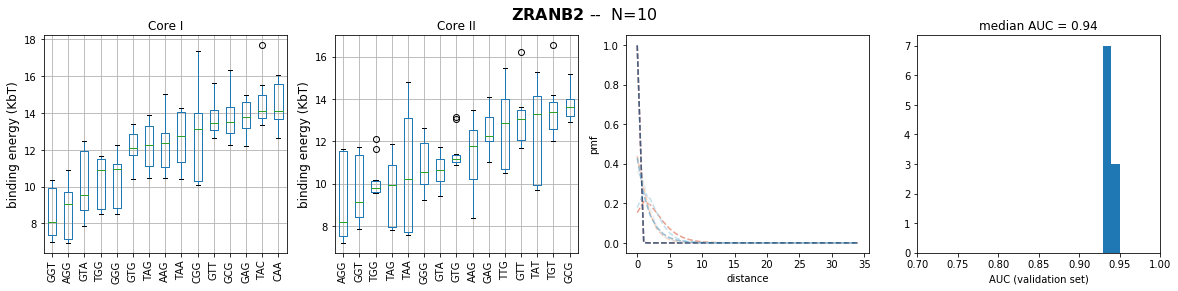

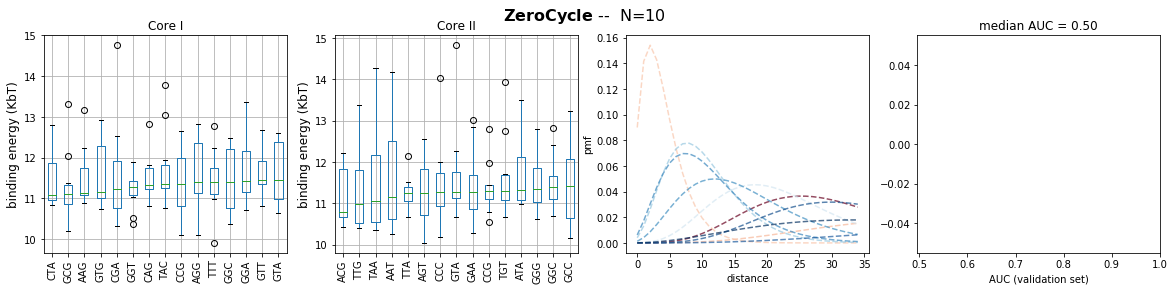

In [5]:
selex_files = np.loadtxt('selex_files.txt', dtype=str)
factors = np.unique([s.split('_')[0] for s in selex_files])
param_dir = 'param/selex/'

pdf = matplotlib.backends.backend_pdf.PdfPages("plots/selex/summary_all_selex.pdf")

for i in range(len(factors)):    
    keyw = f'{factors[i]}_4vs0'  #the keyword which assigns the files to a batch

    param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

    to_pick = [s.startswith(keyw) for s in param_files]
    param_files = list(compress(param_files, to_pick))

    #print('number of files: %d'%len(param_files))
    adam_params = read_params(param_files)

    #structure data as pandas DF
    colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL', 'auct', 'aucv']

    data = pd.DataFrame(adam_params, columns=colnames)
    core1 = data.iloc[:,:len(kmer_inx)]
    core1 = core1.loc[:,core1.median().sort_values().index]
    core2 = data.iloc[:,len(kmer_inx):2*len(kmer_inx)]
    core2 = core2.loc[:,core2.median().sort_values().index]

    #=== plot motifs =================
    fig, axes = plt.subplots(1,4, figsize=(20,4))
    
    fig.suptitle('$\\bf{%s}$'%factors[i] + f' --  N={len(data)}\n', fontsize=16)
    
    plt.subplots_adjust(hspace=0.3)

    ax1, ax2 , ax3, ax4 = axes
    
    n_top_kmers = 15
    core1.iloc[:,:n_top_kmers].boxplot(ax=ax1, rot=90)
    ax1.set_title('Core I', fontsize=12)
    ax1.set_ylabel('binding energy (KbT)', fontsize=12)

    core2.iloc[:,:n_top_kmers].boxplot(ax=ax2, rot=90)
    ax2.set_title('Core II', fontsize=12)
    ax2.set_ylabel('binding energy (KbT)', fontsize=12)


    #=====================

    r = data.sort_values(by='LL')['r'].values
    p = data.sort_values(by='LL')['p'].values
    ll = -data.sort_values(by='LL')['LL'].values

    #== plot distance distributions =================

    xx = np.arange(35)
    cmap = matplotlib.cm.get_cmap('RdBu_r')
    colors = (ll-min(ll))/(max(ll)-min(ll))
    colors = [cmap(c) for c in colors]

    for i in range(len(r)):
        ax3.plot(xx, nbinom.pmf(xx, r[i], p[i]), alpha=0.7, color=colors[i], linestyle='--', label=f'LL={ll[i]:.1f}')

    #ax3.legend()    
    ax3.set_xlabel('distance')
    ax3.set_ylabel('pmf')

    #== plot cross-validation scores ====

    _ = ax4.hist(data.loc[:,'aucv'].values, bins=np.arange(0.7,1,0.01))
    ax4.set_xlabel('AUC (validation set)')
    ax4.set_title(f'median AUC = {np.median(data.aucv.values):0.2f}')
    ax4.set_xlim(min(data.loc[:,'aucv'].min(), 0.7),1)

    pdf.savefig(fig, bbox_inches='tight')
    
pdf.close()

## create summary AUC and distance plots

In [ ]:
selex_files = np.loadtxt('selex_files.txt', dtype=str)
factors = np.unique([s.split('_')[0] for s in selex_files])
param_dir = 'param/selex/'

pdf = matplotlib.backends.backend_pdf.PdfPages("plots/selex/summary_all_selex.pdf")

auc_all = []
distance_all = []

for i in range(len(factors)):    
    keyw = f'{factors[i]}_4vs0'  #the keyword which assigns the files to a batch

    param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

    to_pick = [s.startswith(keyw) for s in param_files]
    param_files = list(compress(param_files, to_pick))

    adam_params = read_params(param_files)

    #structure data as pandas DF
    colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL', 'auct', 'aucv']

    data = pd.DataFrame(adam_params, columns=colnames)

    #=====================

    r = data.sort_values(by='LL')['r'].values[0]
    p = data.sort_values(by='LL')['p'].values[0]
    dist = ((1-p)*r)/p
    distance_all.append(dist)
    
    auc = data.sort_values(by='LL')['aucv'].values[0]
    auc_all.append(auc)
    
    
#plot results

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(9,7))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

_ = ax1.hist(auc_all, bins=np.arange(0.5,1,0.01))
ax1.set_xlabel('AUC (validation set)')
ax1.set_title(f'median AUC = {np.median(auc_all):0.2f}')

_ = ax2.hist(distance_all, bins=np.arange(0,35,0.5))
ax2.set_xlabel('distance between cores (nt)')
ax2.set_title(f'median distance = {np.median(distance_all):0.2f}')
plt.savefig('plots/selex/summary_stats.pdf', bbox_inches='tight')
plt.show()